rework of ch_9_2_first_nns.ipnynb to make cnns  
utilizing csv instead of loading as images   
6. 15x20 // CNN 1D LSTM // 3 - Live Data vs PerfectFam vs StreakMM  

# IMPORTS

In [8]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [9]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import matplotlib.pyplot as plt



# Read CSV of All Data

In [14]:
df_alldata = pd.read_csv('combined_dataset.csv')
# display(df_alldata)

In [15]:
df_alldata.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,2,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,2,perfectmm_456_1
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,2,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,2,perfectmm_456_3
4,1,0,0,0,0,0,0,1,1,1,...,1,0,0,0,1,0,1,1,2,perfectmm_456_4


# Prepare Dataframes
- Remove Live Data (0)  
- Check Labels ...   
=>  
Live Data : 0  
NearPerfectMM : 1    
PerfectMM : 2  
StreakMM : 3  

In [19]:
df_w_live = df_alldata.copy()

# display(df_wo_live)

## Check current labels

In [22]:
orig_labels = list(df_w_live['labels'])

In [23]:
len(orig_labels)

132127

In [29]:
set(orig_labels)
### 0: live_data
### 1: nearperfectmm
### 2: perfectmm
### 3: streakmm

{0, 1, 2, 3}

## Relabel Accordingly
live_data 0 -> 0  
nearperfectmm 1 -> 1  
perfectmm 2 -> 1   
streakmm 3 -> 2

In [33]:
replaced_labels = [1 if x==2 else x for x in orig_labels]
set(replaced_labels)

{0, 1, 3}

In [35]:
replaced_labels = [2 if x==3 else x for x in replaced_labels]
set(replaced_labels)

{0, 1, 2}

In [37]:
df_w_live['labels'] = replaced_labels

In [39]:
set(df_w_live['labels'])

{0, 1, 2}

## Display Current Dataframe

In [45]:
df_w_live[df_w_live['labels']==0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
90000,1,1,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,좋은챔프
90001,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,진기장판


In [47]:
df_w_live[df_w_live['labels']==0].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
132125,0,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,1,0,너가능성잇써
132126,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,0,토꽃


In [49]:
df_w_live[df_w_live['labels']==1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,1,perfectmm_456_1


In [51]:
df_w_live[df_w_live['labels']==1].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
59998,1,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,1,1,nearperfectmm_457_998
59999,0,1,1,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,nearperfectmm_457_999


In [53]:
df_w_live[df_w_live['labels']==2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
60000,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,2,streakmm_412_0
60001,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,1,1,1,1,2,streakmm_412_1


In [55]:
df_w_live[df_w_live['labels']==2].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
89998,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,2,streakmm_386_998
89999,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,2,streakmm_386_999


In [248]:
len(df_w_live[df_w_live['labels']==0])

42127

In [57]:
df_w_live[df_w_live['labels']==3].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths


# Create Pytorch Dataset (custom)

## Define Dataset Class

In [62]:
# Custom Dataset Class
## Needs ATLEAST 3 class methods
## __init__, __len__, __getitem__

class RecordsDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, pd_df):
        # load data
        self.df=pd_df
        # extract labels
        self.df_labels=self.df[['labels']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # self.df=df.drop(columns=['Type','Color','Spectral_Class'])
        
        # convert to torch dtypes
        # self.dataset = self.df[[0,1]]
        # self.dataset=torch.tensor(self.df[[i for i in range(300)]].to_numpy()).float()
        self.dataset=torch.tensor(self.df[[str(i) for i in range(300)]].to_numpy()).float()
        # self.dataset = self.df[[str(i) for i in range(10)]]
        
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

## Instantiate Dataset Class

In [66]:
all_dataset = RecordsDataset(df_w_live)

## Split Train & Test

In [70]:
train_size = int(0.7 * len(all_dataset))
test_size = len(all_dataset) - train_size
# train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1))
### torch.Generator().manual_seed(42)

In [72]:
train_alldataset
len(train_alldataset)

92488

In [74]:
test_alldataset
len(test_alldataset)

39639

## Create Train & Test all_dataloaders

In [78]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [80]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [84]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

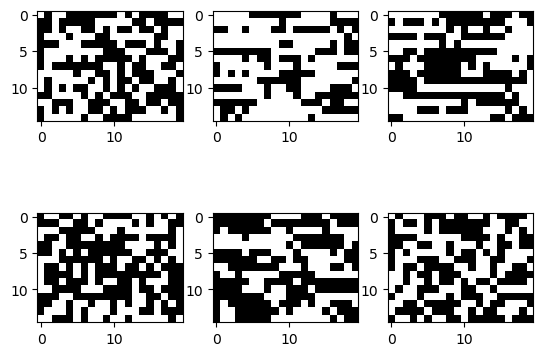

In [86]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)

# example_data.shape
# example_data[0].reshape(15,20)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [87]:
print(example_targets)

tensor([1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1,
        0, 1, 1, 1, 2, 1, 2, 0])


### Check Test alldataloader

In [92]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

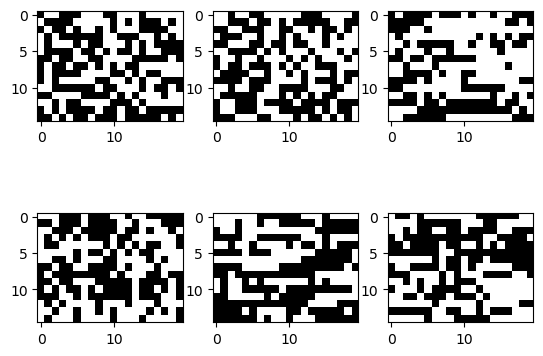

In [94]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [96]:
print(example_targets)

tensor([1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 2, 2, 1, 2,
        1, 1, 2, 0, 1, 1, 2, 0])


# Create First CNN
- Live Data vs (PerfectMM & NearPerfectMM) v StreakMM


## Configurations (Hyperparameters)

In [207]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters
input_size = 15*20 # originally 348x465 before resize

num_classes = 3


# num_epochs = 1
# num_epochs = 2
# num_epochs = 10
# num_epochs = 20
# num_epochs = 50
# num_epochs = 100
num_epochs = 300
# num_epochs = 500
# num_epochs = 1000

learning_rate = 0.0003

In [209]:
print(device)

mps


## Define Model

In [212]:
### cnn_flat_v8.1_lstm_1drop_10epo.pth
### cnn_flat_v8.2_lstm_1drop_300epo.pth


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=7, padding='same')
        # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same')
        # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
        self.fc1 = nn.Linear(16*18, 128)
        # self.fc2 = nn.Linear(128, 64)
        
        self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64, num_layers=1)
        # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
        # self.lstm2 = nn.LSTM(input_size=64, batch_first=True, bidirectional=True, hidden_size=32)
        
        
        self.fc2 = nn.Linear(64, num_classes)
        
        self.drop1 = nn.Dropout(p=0.3)
        # self.drop2 = nn.Dropout(p=0.3)
        

    def forward(self, x):
        # print(f'{x.shape}')       # batch_size, 300
        
        x = x.reshape(-1, 1, 300)
        # print(x.shape)      # batch_size, 1, 300
        
        x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 256, 150
        # print(x.shap/e)
        x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 128, 75
        # print(x.shape)
        x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 37
        # print(x.shape)
        x = F.relu(self.conv4(x))   # -> batch_size, 32, 37
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 18
        # print(x.shape)
        x = F.relu(self.conv5(x))   # -> batch_size, 16, 18
        # print(x.shape)

        x = torch.flatten(x, 1)     # -> batch_size, 288
        # print(f'flatten1: {x.shape}')
        x = self.drop1(x)
        
        # x, _ = self.lstm1(x)     # -> batch_size, 16
        # print(f'lstm1: {x.shape}')
        # # print(x)
        
        # x, _ = self.lstm2(x)     # -> batch_size, 16
        # print(f'lstm2: {x.shape}')
        
        
        x = F.relu(self.fc1(x), 1)     # -> batch_size, 128
        # x = self.drop1(x)
        # print(x.shape)
        
        x, _ = self.lstm1(x)     # -> batch_size, 64*2
        # print(f'lstm1: {x.shape}')
        
        # x, _ = self.lstm2(x)     # -> batch_size, 16
        # print(f'lstm2: {x.shape}')
        
        x = torch.flatten(x, 1)     # -> batch_size, 128
        # print(f'flatten2: {x.shape}')
        
        x = self.fc2(x)             # -> batch_size, num_classes(=3)
        # print(x.shape)
    
        
        return x
    
    
    
#######################    
# torch.Size([32, 300])
# torch.Size([32, 1, 300])
# torch.Size([32, 256, 300])
# torch.Size([32, 128, 150])
# torch.Size([32, 128, 75])
# torch.Size([32, 64, 75])
# torch.Size([32, 64, 37])
# torch.Size([32, 32, 37])
# torch.Size([32, 32, 18])
# torch.Size([32, 16, 18])
# flatten1: torch.Size([32, 288])
# torch.Size([32, 64])
# lstm1: torch.Size([32, 16])
# lstm2: torch.Size([32, 16])
# flatten2: torch.Size([32, 16])
# torch.Size([32, 3])


### apprx 30 seconds per epoch to train (mps, w/ 1 dropout, Adam)

### 10 epochs, initial loss: 0.608, final loss: 0.504 // 5 mins
### 50 epochs // initial loss: , final loss:  // 25 mins
### 100 epochs // initial loss: 0.586, final loss:  // 50 mins
### 300 epochs // initial loss: 0.569, final loss: 0.179 // 5176 secs


In [214]:
# ### cnn_flat_v8.3_lstm_1drop_10epo.pth


# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=5, padding='same')
#         # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
#         self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
# #         self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
# #         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
# #         self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
# #         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(32*37, 128)
#         # self.fc2 = nn.Linear(128, 64)
        
#         self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=False, hidden_size=64, num_layers=1)
#         # self.lstm1 = nn.LSTM(input_size=128, batch_first=True, bidirectional=True, hidden_size=64, num_layers=2, dropout=0.25)
#         self.lstm2 = nn.LSTM(input_size=64, batch_first=True, bidirectional=False, hidden_size=32)
        
        
#         self.fc2 = nn.Linear(32, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        

#     def forward(self, x):
#         # print(f'{x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 128, 300
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 128, 150
#         # print(x.shape)
#         x = F.relu(self.conv2(x))   # -> batch_size, 64, 150
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 64, 75
#         # print(x.shape)
#         x = F.relu(self.conv3(x))   # -> batch_size, 32, 75
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 32, 37
#         # print(x.shape)
        

#         x = torch.flatten(x, 1)     # -> batch_size, 1184
#         # print(f'flatten1: {x.shape}')
#         x = self.drop1(x)
        
#         # x, _ = self.lstm1(x)     # -> batch_size, 16
#         # print(f'lstm1: {x.shape}')
#         # # print(x)
        
#         # x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
        
#         x = F.relu(self.fc1(x), 1)     # -> batch_size, 128
#         # print(x.shape)
        
#         x, _ = self.lstm1(x)     # -> batch_size, 64
#         # print(f'lstm1: {x.shape}')
        
#         x, _ = self.lstm2(x)     # -> batch_size, 16
#         # print(f'lstm2: {x.shape}')
        
#         x = torch.flatten(x, 1)     # -> batch_size, 128
#         # print(f'flatten2: {x.shape}')
        
#         x = self.fc2(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 128, 300])
# # torch.Size([32, 128, 150])
# # torch.Size([32, 64, 150])
# # torch.Size([32, 64, 75])
# # torch.Size([32, 32, 75])
# # torch.Size([32, 32, 37])
# # flatten1: torch.Size([32, 1184])
# # torch.Size([32, 128])
# # lstm1: torch.Size([32, 64])
# # lstm2: torch.Size([32, 32])
# # flatten2: torch.Size([32, 32])
# # torch.Size([32, 3])

# ### apprx 20 seconds per epoch to train (mps, w/ 1 dropout, Adam)

# ### 10 epochs, initial loss: , final loss:  // 
# ### 50 epochs // initial loss: , final loss:  // 
# ### 100 epochs // initial loss: , final loss:  // 
# ### 500 epochs // initial loss: , final loss:   // 



## Train First CNN

In [217]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_alldataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_alldataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
# torch.save(model.state_dict(), PATH)

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))




### apprx 10 seconds per epoch to train (mps, w/ 1 dropout, Adam, softmax)



2024-05-22 13:00:17




  1%|          | 1/100 [00:16<26:27, 16.04s/it]

[1] loss: 0.560


  2%|▏         | 2/100 [00:33<27:23, 16.77s/it]

[2] loss: 0.521


  3%|▎         | 3/100 [00:50<27:41, 17.13s/it]

[3] loss: 0.517


  4%|▍         | 4/100 [01:07<27:14, 17.03s/it]

[4] loss: 0.510


  5%|▌         | 5/100 [01:25<27:08, 17.15s/it]

[5] loss: 0.506


  6%|▌         | 6/100 [01:42<26:46, 17.09s/it]

[6] loss: 0.503


  7%|▋         | 7/100 [01:59<26:28, 17.08s/it]

[7] loss: 0.501


  8%|▊         | 8/100 [02:16<26:08, 17.05s/it]

[8] loss: 0.499


  9%|▉         | 9/100 [02:33<26:04, 17.19s/it]

[9] loss: 0.497


 10%|█         | 10/100 [02:50<25:42, 17.14s/it]

[10] loss: 0.496


 11%|█         | 11/100 [03:07<25:23, 17.12s/it]

[11] loss: 0.494


 12%|█▏        | 12/100 [03:25<25:11, 17.17s/it]

[12] loss: 0.492


 13%|█▎        | 13/100 [03:42<24:49, 17.12s/it]

[13] loss: 0.490


 14%|█▍        | 14/100 [03:59<24:31, 17.11s/it]

[14] loss: 0.488


 15%|█▌        | 15/100 [04:16<24:10, 17.06s/it]

[15] loss: 0.485


 16%|█▌        | 16/100 [04:33<24:05, 17.21s/it]

[16] loss: 0.483


 17%|█▋        | 17/100 [04:50<23:47, 17.20s/it]

[17] loss: 0.480


 18%|█▊        | 18/100 [05:07<23:25, 17.14s/it]

[18] loss: 0.477


 19%|█▉        | 19/100 [05:25<23:13, 17.20s/it]

[19] loss: 0.473


 20%|██        | 20/100 [05:42<22:51, 17.14s/it]

[20] loss: 0.469


 21%|██        | 21/100 [05:59<22:35, 17.16s/it]

[21] loss: 0.465


 22%|██▏       | 22/100 [06:16<22:16, 17.13s/it]

[22] loss: 0.461


 23%|██▎       | 23/100 [06:33<22:04, 17.20s/it]

[23] loss: 0.457


 24%|██▍       | 24/100 [06:50<21:43, 17.16s/it]

[24] loss: 0.452


 25%|██▌       | 25/100 [07:07<21:23, 17.11s/it]

[25] loss: 0.448


 26%|██▌       | 26/100 [07:25<21:07, 17.13s/it]

[26] loss: 0.442


 27%|██▋       | 27/100 [07:41<20:46, 17.08s/it]

[27] loss: 0.438


 28%|██▊       | 28/100 [07:59<20:30, 17.10s/it]

[28] loss: 0.431


 29%|██▉       | 29/100 [08:16<20:12, 17.07s/it]

[29] loss: 0.428


 30%|███       | 30/100 [08:33<20:05, 17.22s/it]

[30] loss: 0.423


 31%|███       | 31/100 [08:50<19:43, 17.16s/it]

[31] loss: 0.419


 32%|███▏      | 32/100 [09:07<19:20, 17.07s/it]

[32] loss: 0.415


 33%|███▎      | 33/100 [09:24<19:10, 17.17s/it]

[33] loss: 0.410


 34%|███▍      | 34/100 [09:41<18:48, 17.10s/it]

[34] loss: 0.406


 35%|███▌      | 35/100 [09:58<18:29, 17.07s/it]

[35] loss: 0.402


 36%|███▌      | 36/100 [10:15<18:10, 17.03s/it]

[36] loss: 0.395


 37%|███▋      | 37/100 [10:33<18:06, 17.25s/it]

[37] loss: 0.393


 38%|███▊      | 38/100 [10:50<17:46, 17.20s/it]

[38] loss: 0.389


 39%|███▉      | 39/100 [11:07<17:25, 17.14s/it]

[39] loss: 0.385


 40%|████      | 40/100 [11:24<17:11, 17.19s/it]

[40] loss: 0.383


 41%|████      | 41/100 [11:42<16:51, 17.15s/it]

[41] loss: 0.378


 42%|████▏     | 42/100 [11:59<16:32, 17.11s/it]

[42] loss: 0.374


 43%|████▎     | 43/100 [12:16<16:12, 17.07s/it]

[43] loss: 0.371


 44%|████▍     | 44/100 [12:33<16:05, 17.24s/it]

[44] loss: 0.367


 45%|████▌     | 45/100 [12:50<15:45, 17.20s/it]

[45] loss: 0.365


 46%|████▌     | 46/100 [13:07<15:23, 17.11s/it]

[46] loss: 0.361


 47%|████▋     | 47/100 [13:25<15:11, 17.20s/it]

[47] loss: 0.356


 48%|████▊     | 48/100 [13:42<14:50, 17.13s/it]

[48] loss: 0.354


 49%|████▉     | 49/100 [13:59<14:31, 17.09s/it]

[49] loss: 0.351


 50%|█████     | 50/100 [14:15<14:12, 17.04s/it]

[50] loss: 0.347


 51%|█████     | 51/100 [14:33<14:01, 17.17s/it]

[51] loss: 0.344


 52%|█████▏    | 52/100 [14:50<13:43, 17.15s/it]

[52] loss: 0.342


 53%|█████▎    | 53/100 [15:07<13:25, 17.14s/it]

[53] loss: 0.341


 54%|█████▍    | 54/100 [15:25<13:12, 17.23s/it]

[54] loss: 0.336


 55%|█████▌    | 55/100 [15:42<12:51, 17.15s/it]

[55] loss: 0.334


 56%|█████▌    | 56/100 [15:59<12:32, 17.10s/it]

[56] loss: 0.332


 57%|█████▋    | 57/100 [16:16<12:13, 17.07s/it]

[57] loss: 0.327


 58%|█████▊    | 58/100 [16:33<12:02, 17.20s/it]

[58] loss: 0.327


 59%|█████▉    | 59/100 [16:50<11:44, 17.17s/it]

[59] loss: 0.323


 60%|██████    | 60/100 [17:07<11:24, 17.10s/it]

[60] loss: 0.322


 61%|██████    | 61/100 [17:25<11:10, 17.20s/it]

[61] loss: 0.320


 62%|██████▏   | 62/100 [17:41<10:50, 17.13s/it]

[62] loss: 0.318


 63%|██████▎   | 63/100 [17:59<10:33, 17.11s/it]

[63] loss: 0.312


 64%|██████▍   | 64/100 [18:16<10:14, 17.06s/it]

[64] loss: 0.312


 65%|██████▌   | 65/100 [18:33<10:01, 17.18s/it]

[65] loss: 0.310


 66%|██████▌   | 66/100 [18:50<09:43, 17.17s/it]

[66] loss: 0.308


 67%|██████▋   | 67/100 [19:07<09:24, 17.12s/it]

[67] loss: 0.307


 68%|██████▊   | 68/100 [19:24<09:09, 17.18s/it]

[68] loss: 0.304


 69%|██████▉   | 69/100 [19:41<08:50, 17.13s/it]

[69] loss: 0.301


 70%|███████   | 70/100 [19:58<08:33, 17.10s/it]

[70] loss: 0.301


 71%|███████   | 71/100 [20:16<08:15, 17.09s/it]

[71] loss: 0.298


 72%|███████▏  | 72/100 [20:33<08:03, 17.27s/it]

[72] loss: 0.294


 73%|███████▎  | 73/100 [20:50<07:44, 17.21s/it]

[73] loss: 0.292


 74%|███████▍  | 74/100 [21:07<07:25, 17.13s/it]

[74] loss: 0.290


 75%|███████▌  | 75/100 [21:25<07:10, 17.21s/it]

[75] loss: 0.290


 76%|███████▌  | 76/100 [21:42<06:51, 17.14s/it]

[76] loss: 0.288


 77%|███████▋  | 77/100 [21:59<06:34, 17.15s/it]

[77] loss: 0.289


 78%|███████▊  | 78/100 [22:16<06:16, 17.09s/it]

[78] loss: 0.284


 79%|███████▉  | 79/100 [22:33<06:00, 17.18s/it]

[79] loss: 0.284


 80%|████████  | 80/100 [22:50<05:43, 17.17s/it]

[80] loss: 0.282


 81%|████████  | 81/100 [23:07<05:25, 17.13s/it]

[81] loss: 0.279


 82%|████████▏ | 82/100 [23:25<05:09, 17.19s/it]

[82] loss: 0.277


 83%|████████▎ | 83/100 [23:42<04:51, 17.13s/it]

[83] loss: 0.275


 84%|████████▍ | 84/100 [23:59<04:33, 17.09s/it]

[84] loss: 0.275


 85%|████████▌ | 85/100 [24:16<04:16, 17.08s/it]

[85] loss: 0.273


 86%|████████▌ | 86/100 [24:33<04:01, 17.24s/it]

[86] loss: 0.272


 87%|████████▋ | 87/100 [24:51<03:44, 17.24s/it]

[87] loss: 0.272


 88%|████████▊ | 88/100 [25:08<03:25, 17.17s/it]

[88] loss: 0.270


 89%|████████▉ | 89/100 [25:25<03:09, 17.24s/it]

[89] loss: 0.269


 90%|█████████ | 90/100 [25:42<02:51, 17.18s/it]

[90] loss: 0.266


 91%|█████████ | 91/100 [25:59<02:34, 17.15s/it]

[91] loss: 0.265


 92%|█████████▏| 92/100 [26:16<02:16, 17.10s/it]

[92] loss: 0.263


 93%|█████████▎| 93/100 [26:34<02:00, 17.23s/it]

[93] loss: 0.262


 94%|█████████▍| 94/100 [26:51<01:43, 17.23s/it]

[94] loss: 0.259


 95%|█████████▌| 95/100 [27:08<01:25, 17.18s/it]

[95] loss: 0.261


 96%|█████████▌| 96/100 [27:25<01:09, 17.29s/it]

[96] loss: 0.257


 97%|█████████▋| 97/100 [27:42<00:51, 17.22s/it]

[97] loss: 0.258


 98%|█████████▊| 98/100 [28:00<00:34, 17.18s/it]

[98] loss: 0.254


 99%|█████████▉| 99/100 [28:17<00:17, 17.18s/it]

[99] loss: 0.254


100%|██████████| 100/100 [28:34<00:00, 17.15s/it]

[100] loss: 0.254
Finished Training

----------------------------------------------------
done in 1714.628s.
2024-05-22 13:28:52


In [171]:
# labels

In [173]:
# model(images)

## Save CNN

In [221]:
# PATH = './models/practice_2/first_basic_nn_20240520.pth'
# PATH = f'./models/practice_3/first_basic_nn_3_{str(num_epochs)}epo.pth'
# PATH = f'./models/practice_3/first_cnn_1d_lstm_8.2_{str(num_epochs)}epo.pth'
# PATH = f'./models/practice_3/first_cnn_1d_lstm_8.3_{str(num_epochs)}epo.pth'
PATH = f'./models/practice_3/first_cnn_1d_lstm_{str(num_epochs)}epo.pth'
print(PATH)

./models/practice_3/first_cnn_1d_lstm_100epo.pth


In [223]:
torch.save(model.state_dict(), PATH)

## Load CNN

In [225]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

ConvNet(
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv1d(1, 256, kernel_size=(7,), stride=(1,), padding=same)
  (conv2): Conv1d(256, 128, kernel_size=(5,), stride=(1,), padding=same)
  (conv3): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv4): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=same)
  (conv5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=same)
  (fc1): Linear(in_features=288, out_features=128, bias=True)
  (lstm1): LSTM(128, 64, batch_first=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
)

## Test CNN

In [230]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################


# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((int(labels_list[i]), predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### 100 ~ 160s

### Accuracy of the loaded model: 53.94240267470429 % (2 epochs)



2024-05-22 13:35:39


Accuracy of the loaded model: 66.57080148338757 %

----------------------------------------------------
done in 6.738s.
2024-05-22 13:35:46


In [231]:
predicted2

tensor([0, 1, 1, 2, 2, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 0, 2, 2, 1, 2, 2],
       device='mps:0')

In [232]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


39639
<class 'list'>


In [233]:
# Counter(all_answers)
all_answers_dict = dict(Counter(all_answers))
all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

# all_answers_dict

###

for kkey in all_answers_dict:
    print(f'{kkey} : {all_answers_dict[kkey]}')



(0, 0) : 6653
(0, 1) : 6164
(0, 2) : 10
(1, 0) : 7073
(1, 1) : 10717
(1, 2) : 2
(2, 0) : 2
(2, 2) : 9018


# CNN Train Loop by Epoch

In [242]:
# num_epochs_list = [1, 3]
# num_epochs_list = [10, 50]
# num_epochs_list = [10, 50]
num_epochs_list = [300, 500]
print(num_epochs_list)

[300, 500]


In [244]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

for one_epoch in num_epochs_list:
    # print(one_epoch)
    model = ConvNet().to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_total_steps = len(train_alldataloader)
    for epoch in tqdm(range(one_epoch)):

        running_loss = 0.0

        for i, (images, labels) in enumerate(train_alldataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()

        print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

    print('Finished Training')


    PATH = f'./models/practice_3/first_cnn_1d_lstm_{str(one_epoch)}epo.pth'

    torch.save(model.state_dict(), PATH)
    
    loaded_model = ConvNet()
    loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
    loaded_model.to(device)
    loaded_model.eval()
    
    
    # wrong_answers = []
    all_answers = []

    with torch.no_grad():
        n_correct = 0
        n_correct2 = 0
        n_samples = len(test_alldataloader.dataset)

        for images, labels in test_alldataloader:
            images = images.to(device)
            labels = labels.to(device)
            # outputs = model(images)

            # max returns (value ,index)
            outputs2 = loaded_model(images)
            _, predicted2 = torch.max(outputs2, 1)

            n_correct2 += (predicted2 == labels).sum().item()


            labels_list = labels.tolist()
            predicted2_list = predicted2.tolist()

            for i in range(len(labels_list)):
                # if predicted2_list[i] != labels_list[i]:
                    # wrong_answers.append([labels_list[i], predicted2_list[i]])
                    all_answers.append((int(labels_list[i]), predicted2_list[i]))

        acc = 100.0 * n_correct2 / n_samples
        print(f'Accuracy of the loaded model: {acc} %')
    
    all_answers_dict = dict(Counter(all_answers))
    all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

    # all_answers_dict

    ###

    print(f'one_epoch : {one_epoch}')
    for kkey in all_answers_dict:
        print(f'{kkey} : {all_answers_dict[kkey]}')
    print('-------')


    
    
##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))

2024-05-22 14:45:23




  0%|          | 1/300 [00:16<1:21:06, 16.28s/it]

[1] loss: 0.564


  1%|          | 2/300 [00:32<1:21:06, 16.33s/it]

[2] loss: 0.521


  1%|          | 3/300 [00:49<1:21:15, 16.41s/it]

[3] loss: 0.518


  1%|▏         | 4/300 [01:06<1:22:12, 16.67s/it]

[4] loss: 0.515


  2%|▏         | 5/300 [01:23<1:22:10, 16.71s/it]

[5] loss: 0.509


  2%|▏         | 6/300 [01:39<1:21:50, 16.70s/it]

[6] loss: 0.504


  2%|▏         | 7/300 [01:56<1:22:07, 16.82s/it]

[7] loss: 0.502


  3%|▎         | 8/300 [02:13<1:22:10, 16.88s/it]

[8] loss: 0.499


  3%|▎         | 9/300 [02:30<1:21:43, 16.85s/it]

[9] loss: 0.498


  3%|▎         | 10/300 [02:47<1:21:33, 16.87s/it]

[10] loss: 0.496


  4%|▎         | 11/300 [03:04<1:21:54, 17.00s/it]

[11] loss: 0.494


  4%|▍         | 12/300 [03:21<1:21:21, 16.95s/it]

[12] loss: 0.493


  4%|▍         | 13/300 [03:38<1:21:00, 16.94s/it]

[13] loss: 0.491


  5%|▍         | 14/300 [03:55<1:21:02, 17.00s/it]

[14] loss: 0.488


  5%|▌         | 15/300 [04:12<1:20:47, 17.01s/it]

[15] loss: 0.486


  5%|▌         | 16/300 [04:29<1:20:28, 17.00s/it]

[16] loss: 0.484


  6%|▌         | 17/300 [04:46<1:19:59, 16.96s/it]

[17] loss: 0.481


  6%|▌         | 18/300 [05:03<1:19:55, 17.01s/it]

[18] loss: 0.477


  6%|▋         | 19/300 [05:20<1:19:47, 17.04s/it]

[19] loss: 0.474


  7%|▋         | 20/300 [05:37<1:19:20, 17.00s/it]

[20] loss: 0.470


  7%|▋         | 21/300 [05:54<1:19:27, 17.09s/it]

[21] loss: 0.466


  7%|▋         | 22/300 [06:12<1:19:12, 17.09s/it]

[22] loss: 0.462


  8%|▊         | 23/300 [06:28<1:18:38, 17.03s/it]

[23] loss: 0.458


  8%|▊         | 24/300 [06:45<1:18:09, 16.99s/it]

[24] loss: 0.453


  8%|▊         | 25/300 [07:03<1:18:21, 17.10s/it]

[25] loss: 0.449


  9%|▊         | 26/300 [07:19<1:17:36, 16.99s/it]

[26] loss: 0.445


  9%|▉         | 27/300 [07:37<1:18:08, 17.17s/it]

[27] loss: 0.441


  9%|▉         | 28/300 [07:57<1:21:47, 18.04s/it]

[28] loss: 0.437


 10%|▉         | 29/300 [08:14<1:20:17, 17.78s/it]

[29] loss: 0.432


 10%|█         | 30/300 [08:31<1:19:15, 17.61s/it]

[30] loss: 0.426


 10%|█         | 31/300 [08:49<1:18:08, 17.43s/it]

[31] loss: 0.423


 11%|█         | 32/300 [09:06<1:17:42, 17.40s/it]

[32] loss: 0.419


 11%|█         | 33/300 [09:23<1:17:09, 17.34s/it]

[33] loss: 0.416


 11%|█▏        | 34/300 [09:40<1:16:30, 17.26s/it]

[34] loss: 0.413


 12%|█▏        | 35/300 [09:58<1:16:26, 17.31s/it]

[35] loss: 0.408


 12%|█▏        | 36/300 [10:15<1:16:01, 17.28s/it]

[36] loss: 0.404


 12%|█▏        | 37/300 [10:32<1:15:41, 17.27s/it]

[37] loss: 0.399


 13%|█▎        | 38/300 [10:49<1:15:16, 17.24s/it]

[38] loss: 0.397


 13%|█▎        | 39/300 [11:07<1:15:12, 17.29s/it]

[39] loss: 0.392


 13%|█▎        | 40/300 [11:24<1:14:46, 17.26s/it]

[40] loss: 0.387


 14%|█▎        | 41/300 [11:41<1:14:18, 17.21s/it]

[41] loss: 0.384


 14%|█▍        | 42/300 [11:58<1:14:06, 17.23s/it]

[42] loss: 0.381


 14%|█▍        | 43/300 [12:15<1:13:34, 17.18s/it]

[43] loss: 0.379


 15%|█▍        | 44/300 [12:33<1:13:31, 17.23s/it]

[44] loss: 0.376


 15%|█▌        | 45/300 [12:50<1:12:56, 17.16s/it]

[45] loss: 0.373


 15%|█▌        | 46/300 [13:07<1:13:09, 17.28s/it]

[46] loss: 0.370


 16%|█▌        | 47/300 [13:24<1:12:44, 17.25s/it]

[47] loss: 0.368


 16%|█▌        | 48/300 [13:41<1:12:19, 17.22s/it]

[48] loss: 0.364


 16%|█▋        | 49/300 [13:59<1:12:23, 17.31s/it]

[49] loss: 0.362


 17%|█▋        | 50/300 [14:16<1:12:00, 17.28s/it]

[50] loss: 0.359


 17%|█▋        | 51/300 [14:33<1:11:36, 17.25s/it]

[51] loss: 0.356


 17%|█▋        | 52/300 [14:51<1:11:12, 17.23s/it]

[52] loss: 0.354


 18%|█▊        | 53/300 [15:08<1:11:03, 17.26s/it]

[53] loss: 0.351


 18%|█▊        | 54/300 [15:25<1:10:43, 17.25s/it]

[54] loss: 0.349


 18%|█▊        | 55/300 [15:42<1:10:35, 17.29s/it]

[55] loss: 0.346


 19%|█▊        | 56/300 [16:00<1:10:22, 17.31s/it]

[56] loss: 0.344


 19%|█▉        | 57/300 [16:17<1:10:02, 17.30s/it]

[57] loss: 0.342


 19%|█▉        | 58/300 [16:34<1:09:51, 17.32s/it]

[58] loss: 0.339


 20%|█▉        | 59/300 [16:52<1:09:29, 17.30s/it]

[59] loss: 0.338


 20%|██        | 60/300 [17:09<1:08:56, 17.24s/it]

[60] loss: 0.335


 20%|██        | 61/300 [17:26<1:08:35, 17.22s/it]

[61] loss: 0.333


 21%|██        | 62/300 [17:43<1:08:11, 17.19s/it]

[62] loss: 0.329


 21%|██        | 63/300 [18:00<1:08:03, 17.23s/it]

[63] loss: 0.328


 21%|██▏       | 64/300 [18:18<1:07:52, 17.26s/it]

[64] loss: 0.327


 22%|██▏       | 65/300 [18:35<1:07:36, 17.26s/it]

[65] loss: 0.325


 22%|██▏       | 66/300 [18:52<1:07:26, 17.29s/it]

[66] loss: 0.322


 22%|██▏       | 67/300 [19:10<1:07:47, 17.46s/it]

[67] loss: 0.322


 23%|██▎       | 68/300 [19:27<1:06:55, 17.31s/it]

[68] loss: 0.318


 23%|██▎       | 69/300 [19:44<1:06:13, 17.20s/it]

[69] loss: 0.317


 23%|██▎       | 70/300 [20:01<1:05:51, 17.18s/it]

[70] loss: 0.317


 24%|██▎       | 71/300 [20:18<1:05:18, 17.11s/it]

[71] loss: 0.313


 24%|██▍       | 72/300 [20:35<1:05:00, 17.11s/it]

[72] loss: 0.310


 24%|██▍       | 73/300 [20:52<1:04:40, 17.10s/it]

[73] loss: 0.309


 25%|██▍       | 74/300 [21:09<1:04:13, 17.05s/it]

[74] loss: 0.310


 25%|██▌       | 75/300 [21:26<1:03:50, 17.02s/it]

[75] loss: 0.305


 25%|██▌       | 76/300 [21:43<1:03:18, 16.96s/it]

[76] loss: 0.307


 26%|██▌       | 77/300 [22:00<1:03:21, 17.05s/it]

[77] loss: 0.302


 26%|██▌       | 78/300 [22:17<1:02:56, 17.01s/it]

[78] loss: 0.302


 26%|██▋       | 79/300 [22:34<1:02:45, 17.04s/it]

[79] loss: 0.300


 27%|██▋       | 80/300 [22:52<1:02:35, 17.07s/it]

[80] loss: 0.298


 27%|██▋       | 81/300 [23:08<1:02:11, 17.04s/it]

[81] loss: 0.295


 27%|██▋       | 82/300 [23:26<1:02:12, 17.12s/it]

[82] loss: 0.296


 28%|██▊       | 83/300 [23:43<1:01:41, 17.06s/it]

[83] loss: 0.294


 28%|██▊       | 84/300 [24:00<1:01:30, 17.08s/it]

[84] loss: 0.293


 28%|██▊       | 85/300 [24:17<1:01:03, 17.04s/it]

[85] loss: 0.292


 29%|██▊       | 86/300 [24:34<1:00:40, 17.01s/it]

[86] loss: 0.288


 29%|██▉       | 87/300 [24:50<1:00:06, 16.93s/it]

[87] loss: 0.289


 29%|██▉       | 88/300 [25:08<1:00:03, 17.00s/it]

[88] loss: 0.287


 30%|██▉       | 89/300 [25:24<59:38, 16.96s/it]  

[89] loss: 0.285


 30%|███       | 90/300 [25:41<59:11, 16.91s/it]

[90] loss: 0.285


 30%|███       | 91/300 [25:59<59:19, 17.03s/it]

[91] loss: 0.283


 31%|███       | 92/300 [26:15<58:50, 16.98s/it]

[92] loss: 0.281


 31%|███       | 93/300 [26:32<58:36, 16.99s/it]

[93] loss: 0.278


 31%|███▏      | 94/300 [26:49<58:15, 16.97s/it]

[94] loss: 0.279


 32%|███▏      | 95/300 [27:07<58:07, 17.01s/it]

[95] loss: 0.277


 32%|███▏      | 96/300 [27:23<57:47, 17.00s/it]

[96] loss: 0.277


 32%|███▏      | 97/300 [27:40<57:17, 16.93s/it]

[97] loss: 0.276


 33%|███▎      | 98/300 [27:57<57:12, 16.99s/it]

[98] loss: 0.276


 33%|███▎      | 99/300 [28:14<57:01, 17.02s/it]

[99] loss: 0.273


 33%|███▎      | 100/300 [28:32<56:52, 17.06s/it]

[100] loss: 0.272


 34%|███▎      | 101/300 [28:48<56:22, 17.00s/it]

[101] loss: 0.272


 34%|███▍      | 102/300 [29:06<56:17, 17.06s/it]

[102] loss: 0.270


 34%|███▍      | 103/300 [29:23<55:50, 17.01s/it]

[103] loss: 0.269


 35%|███▍      | 104/300 [29:39<55:20, 16.94s/it]

[104] loss: 0.266


 35%|███▌      | 105/300 [29:56<55:13, 16.99s/it]

[105] loss: 0.265


 35%|███▌      | 106/300 [30:14<55:18, 17.11s/it]

[106] loss: 0.266


 36%|███▌      | 107/300 [30:31<54:55, 17.07s/it]

[107] loss: 0.263


 36%|███▌      | 108/300 [30:48<54:22, 16.99s/it]

[108] loss: 0.263


 36%|███▋      | 109/300 [31:05<54:20, 17.07s/it]

[109] loss: 0.264


 37%|███▋      | 110/300 [31:22<53:55, 17.03s/it]

[110] loss: 0.262


 37%|███▋      | 111/300 [31:39<53:28, 16.98s/it]

[111] loss: 0.260


 37%|███▋      | 112/300 [31:56<53:18, 17.01s/it]

[112] loss: 0.258


 38%|███▊      | 113/300 [32:13<53:08, 17.05s/it]

[113] loss: 0.257


 38%|███▊      | 114/300 [32:30<52:54, 17.07s/it]

[114] loss: 0.256


 38%|███▊      | 115/300 [32:47<52:25, 17.00s/it]

[115] loss: 0.254


 39%|███▊      | 116/300 [33:04<52:18, 17.06s/it]

[116] loss: 0.254


 39%|███▉      | 117/300 [33:21<51:49, 16.99s/it]

[117] loss: 0.252


 39%|███▉      | 118/300 [33:38<51:33, 16.99s/it]

[118] loss: 0.251


 40%|███▉      | 119/300 [33:55<51:28, 17.06s/it]

[119] loss: 0.250


 40%|████      | 120/300 [34:12<51:19, 17.11s/it]

[120] loss: 0.251


 40%|████      | 121/300 [34:30<51:14, 17.18s/it]

[121] loss: 0.250


 41%|████      | 122/300 [34:47<50:39, 17.08s/it]

[122] loss: 0.249


 41%|████      | 123/300 [35:04<50:38, 17.16s/it]

[123] loss: 0.247


 41%|████▏     | 124/300 [35:21<50:08, 17.09s/it]

[124] loss: 0.244


 42%|████▏     | 125/300 [35:38<49:41, 17.04s/it]

[125] loss: 0.244


 42%|████▏     | 126/300 [35:55<49:39, 17.12s/it]

[126] loss: 0.245


 42%|████▏     | 127/300 [36:12<49:29, 17.16s/it]

[127] loss: 0.244


 43%|████▎     | 128/300 [36:29<49:03, 17.12s/it]

[128] loss: 0.243


 43%|████▎     | 129/300 [36:46<48:41, 17.08s/it]

[129] loss: 0.242


 43%|████▎     | 130/300 [37:03<48:27, 17.10s/it]

[130] loss: 0.241


 44%|████▎     | 131/300 [37:20<47:59, 17.04s/it]

[131] loss: 0.241


 44%|████▍     | 132/300 [37:37<47:36, 17.00s/it]

[132] loss: 0.239


 44%|████▍     | 133/300 [37:54<47:30, 17.07s/it]

[133] loss: 0.238


 45%|████▍     | 134/300 [38:12<47:16, 17.09s/it]

[134] loss: 0.236


 45%|████▌     | 135/300 [38:29<47:06, 17.13s/it]

[135] loss: 0.239


 45%|████▌     | 136/300 [38:46<46:34, 17.04s/it]

[136] loss: 0.237


 46%|████▌     | 137/300 [39:03<46:27, 17.10s/it]

[137] loss: 0.233


 46%|████▌     | 138/300 [39:20<46:00, 17.04s/it]

[138] loss: 0.235


 46%|████▋     | 139/300 [39:37<45:35, 16.99s/it]

[139] loss: 0.237


 47%|████▋     | 140/300 [39:54<45:26, 17.04s/it]

[140] loss: 0.235


 47%|████▋     | 141/300 [40:11<45:11, 17.05s/it]

[141] loss: 0.235


 47%|████▋     | 142/300 [40:28<44:52, 17.04s/it]

[142] loss: 0.232


 48%|████▊     | 143/300 [40:45<44:29, 17.00s/it]

[143] loss: 0.233


 48%|████▊     | 144/300 [41:02<44:32, 17.13s/it]

[144] loss: 0.232


 48%|████▊     | 145/300 [41:19<44:04, 17.06s/it]

[145] loss: 0.231


 49%|████▊     | 146/300 [41:36<43:46, 17.05s/it]

[146] loss: 0.234


 49%|████▉     | 147/300 [41:53<43:30, 17.06s/it]

[147] loss: 0.232


 49%|████▉     | 148/300 [42:10<43:18, 17.09s/it]

[148] loss: 0.227


 50%|████▉     | 149/300 [42:28<42:59, 17.08s/it]

[149] loss: 0.227


 50%|█████     | 150/300 [42:44<42:29, 17.00s/it]

[150] loss: 0.227


 50%|█████     | 151/300 [43:01<42:19, 17.05s/it]

[151] loss: 0.229


 51%|█████     | 152/300 [43:19<42:01, 17.04s/it]

[152] loss: 0.229


 51%|█████     | 153/300 [43:36<41:43, 17.03s/it]

[153] loss: 0.225


 51%|█████▏    | 154/300 [43:53<41:30, 17.06s/it]

[154] loss: 0.225


 52%|█████▏    | 155/300 [44:10<41:19, 17.10s/it]

[155] loss: 0.225


 52%|█████▏    | 156/300 [44:27<41:00, 17.09s/it]

[156] loss: 0.222


 52%|█████▏    | 157/300 [44:44<40:39, 17.06s/it]

[157] loss: 0.224


 53%|█████▎    | 158/300 [45:01<40:25, 17.08s/it]

[158] loss: 0.220


 53%|█████▎    | 159/300 [45:18<40:03, 17.05s/it]

[159] loss: 0.223


 53%|█████▎    | 160/300 [45:35<39:49, 17.07s/it]

[160] loss: 0.222


 54%|█████▎    | 161/300 [45:52<39:33, 17.07s/it]

[161] loss: 0.223


 54%|█████▍    | 162/300 [46:10<39:27, 17.16s/it]

[162] loss: 0.222


 54%|█████▍    | 163/300 [46:27<39:28, 17.29s/it]

[163] loss: 0.220


 55%|█████▍    | 164/300 [46:44<38:50, 17.14s/it]

[164] loss: 0.218


 55%|█████▌    | 165/300 [47:01<38:40, 17.19s/it]

[165] loss: 0.218


 55%|█████▌    | 166/300 [47:18<38:11, 17.10s/it]

[166] loss: 0.218


 56%|█████▌    | 167/300 [47:35<37:44, 17.03s/it]

[167] loss: 0.217


 56%|█████▌    | 168/300 [47:52<37:31, 17.06s/it]

[168] loss: 0.217


 56%|█████▋    | 169/300 [48:09<37:21, 17.11s/it]

[169] loss: 0.217


 57%|█████▋    | 170/300 [48:26<37:02, 17.10s/it]

[170] loss: 0.219


 57%|█████▋    | 171/300 [48:43<36:43, 17.08s/it]

[171] loss: 0.216


 57%|█████▋    | 172/300 [49:01<36:33, 17.13s/it]

[172] loss: 0.214


 58%|█████▊    | 173/300 [49:18<36:03, 17.03s/it]

[173] loss: 0.212


 58%|█████▊    | 174/300 [49:35<35:46, 17.04s/it]

[174] loss: 0.213


 58%|█████▊    | 175/300 [49:52<35:30, 17.04s/it]

[175] loss: 0.216


 59%|█████▊    | 176/300 [50:09<35:17, 17.08s/it]

[176] loss: 0.216


 59%|█████▉    | 177/300 [50:26<35:00, 17.07s/it]

[177] loss: 0.210


 59%|█████▉    | 178/300 [50:43<34:37, 17.03s/it]

[178] loss: 0.215


 60%|█████▉    | 179/300 [51:00<34:34, 17.15s/it]

[179] loss: 0.212


 60%|██████    | 180/300 [51:17<34:08, 17.07s/it]

[180] loss: 0.210


 60%|██████    | 181/300 [51:34<33:45, 17.02s/it]

[181] loss: 0.211


 61%|██████    | 182/300 [51:51<33:25, 17.00s/it]

[182] loss: 0.212


 61%|██████    | 183/300 [52:08<33:20, 17.10s/it]

[183] loss: 0.210


 61%|██████▏   | 184/300 [52:25<32:58, 17.06s/it]

[184] loss: 0.210


 62%|██████▏   | 185/300 [52:42<32:37, 17.02s/it]

[185] loss: 0.210


 62%|██████▏   | 186/300 [52:59<32:25, 17.07s/it]

[186] loss: 0.204


 62%|██████▏   | 187/300 [53:16<32:03, 17.02s/it]

[187] loss: 0.209


 63%|██████▎   | 188/300 [53:34<32:00, 17.15s/it]

[188] loss: 0.207


 63%|██████▎   | 189/300 [53:51<31:48, 17.19s/it]

[189] loss: 0.207


 63%|██████▎   | 190/300 [54:08<31:32, 17.21s/it]

[190] loss: 0.211


 64%|██████▎   | 191/300 [54:25<31:06, 17.12s/it]

[191] loss: 0.205


 64%|██████▍   | 192/300 [54:42<30:39, 17.03s/it]

[192] loss: 0.207


 64%|██████▍   | 193/300 [54:59<30:30, 17.11s/it]

[193] loss: 0.208


 65%|██████▍   | 194/300 [55:16<30:13, 17.11s/it]

[194] loss: 0.207


 65%|██████▌   | 195/300 [55:33<29:52, 17.07s/it]

[195] loss: 0.204


 65%|██████▌   | 196/300 [55:50<29:30, 17.03s/it]

[196] loss: 0.204


 66%|██████▌   | 197/300 [56:08<29:23, 17.12s/it]

[197] loss: 0.205


 66%|██████▌   | 198/300 [56:25<29:05, 17.11s/it]

[198] loss: 0.204


 66%|██████▋   | 199/300 [56:42<28:44, 17.07s/it]

[199] loss: 0.206


 67%|██████▋   | 200/300 [56:59<28:32, 17.13s/it]

[200] loss: 0.205


 67%|██████▋   | 201/300 [57:16<28:12, 17.10s/it]

[201] loss: 0.202


 67%|██████▋   | 202/300 [57:33<27:52, 17.06s/it]

[202] loss: 0.202


 68%|██████▊   | 203/300 [57:50<27:33, 17.05s/it]

[203] loss: 0.202


 68%|██████▊   | 204/300 [58:07<27:27, 17.16s/it]

[204] loss: 0.204


 68%|██████▊   | 205/300 [58:24<27:05, 17.11s/it]

[205] loss: 0.200


 69%|██████▊   | 206/300 [58:41<26:45, 17.08s/it]

[206] loss: 0.201


 69%|██████▉   | 207/300 [58:59<26:39, 17.20s/it]

[207] loss: 0.202


 69%|██████▉   | 208/300 [59:16<26:21, 17.19s/it]

[208] loss: 0.202


 70%|██████▉   | 209/300 [59:33<26:02, 17.17s/it]

[209] loss: 0.202


 70%|███████   | 210/300 [59:50<25:41, 17.13s/it]

[210] loss: 0.200


 70%|███████   | 211/300 [1:00:08<25:31, 17.21s/it]

[211] loss: 0.199


 71%|███████   | 212/300 [1:00:25<25:11, 17.18s/it]

[212] loss: 0.201


 71%|███████   | 213/300 [1:00:42<24:47, 17.10s/it]

[213] loss: 0.200


 71%|███████▏  | 214/300 [1:00:59<24:39, 17.21s/it]

[214] loss: 0.200


 72%|███████▏  | 215/300 [1:01:16<24:18, 17.16s/it]

[215] loss: 0.198


 72%|███████▏  | 216/300 [1:01:33<23:54, 17.07s/it]

[216] loss: 0.197


 72%|███████▏  | 217/300 [1:01:50<23:35, 17.06s/it]

[217] loss: 0.198


 73%|███████▎  | 218/300 [1:02:07<23:26, 17.16s/it]

[218] loss: 0.198


 73%|███████▎  | 219/300 [1:02:24<23:06, 17.12s/it]

[219] loss: 0.197


 73%|███████▎  | 220/300 [1:02:41<22:42, 17.03s/it]

[220] loss: 0.196


 74%|███████▎  | 221/300 [1:02:59<22:33, 17.13s/it]

[221] loss: 0.198


 74%|███████▍  | 222/300 [1:03:16<22:12, 17.09s/it]

[222] loss: 0.197


 74%|███████▍  | 223/300 [1:03:33<21:53, 17.06s/it]

[223] loss: 0.196


 75%|███████▍  | 224/300 [1:03:50<21:37, 17.08s/it]

[224] loss: 0.196


 75%|███████▌  | 225/300 [1:04:07<21:27, 17.16s/it]

[225] loss: 0.195


 75%|███████▌  | 226/300 [1:04:24<21:09, 17.15s/it]

[226] loss: 0.196


 76%|███████▌  | 227/300 [1:04:41<20:47, 17.09s/it]

[227] loss: 0.198


 76%|███████▌  | 228/300 [1:04:58<20:34, 17.14s/it]

[228] loss: 0.194


 76%|███████▋  | 229/300 [1:05:15<20:12, 17.08s/it]

[229] loss: 0.196


 77%|███████▋  | 230/300 [1:05:32<19:51, 17.02s/it]

[230] loss: 0.194


 77%|███████▋  | 231/300 [1:05:49<19:34, 17.02s/it]

[231] loss: 0.193


 77%|███████▋  | 232/300 [1:06:07<19:25, 17.15s/it]

[232] loss: 0.197


 78%|███████▊  | 233/300 [1:06:24<19:08, 17.15s/it]

[233] loss: 0.194


 78%|███████▊  | 234/300 [1:06:41<18:47, 17.09s/it]

[234] loss: 0.197


 78%|███████▊  | 235/300 [1:06:58<18:38, 17.21s/it]

[235] loss: 0.194


 79%|███████▊  | 236/300 [1:07:15<18:15, 17.12s/it]

[236] loss: 0.193


 79%|███████▉  | 237/300 [1:07:33<18:17, 17.43s/it]

[237] loss: 0.193


 79%|███████▉  | 238/300 [1:07:50<17:49, 17.26s/it]

[238] loss: 0.194


 80%|███████▉  | 239/300 [1:08:07<17:30, 17.23s/it]

[239] loss: 0.194


 80%|████████  | 240/300 [1:08:25<17:13, 17.22s/it]

[240] loss: 0.194


 80%|████████  | 241/300 [1:08:41<16:49, 17.11s/it]

[241] loss: 0.194


 81%|████████  | 242/300 [1:08:59<16:38, 17.21s/it]

[242] loss: 0.193


 81%|████████  | 243/300 [1:09:16<16:16, 17.13s/it]

[243] loss: 0.191


 81%|████████▏ | 244/300 [1:09:33<15:56, 17.07s/it]

[244] loss: 0.193


 82%|████████▏ | 245/300 [1:09:50<15:38, 17.06s/it]

[245] loss: 0.190


 82%|████████▏ | 246/300 [1:10:07<15:27, 17.18s/it]

[246] loss: 0.191


 82%|████████▏ | 247/300 [1:10:24<15:08, 17.13s/it]

[247] loss: 0.191


 83%|████████▎ | 248/300 [1:10:41<14:46, 17.05s/it]

[248] loss: 0.192


 83%|████████▎ | 249/300 [1:10:58<14:33, 17.12s/it]

[249] loss: 0.191


 83%|████████▎ | 250/300 [1:11:15<14:10, 17.01s/it]

[250] loss: 0.190


 84%|████████▎ | 251/300 [1:11:32<13:55, 17.05s/it]

[251] loss: 0.193


 84%|████████▍ | 252/300 [1:11:49<13:36, 17.01s/it]

[252] loss: 0.189


 84%|████████▍ | 253/300 [1:12:07<13:23, 17.10s/it]

[253] loss: 0.189


 85%|████████▍ | 254/300 [1:12:24<13:08, 17.14s/it]

[254] loss: 0.192


 85%|████████▌ | 255/300 [1:12:41<12:46, 17.04s/it]

[255] loss: 0.190


 85%|████████▌ | 256/300 [1:12:58<12:32, 17.11s/it]

[256] loss: 0.189


 86%|████████▌ | 257/300 [1:13:15<12:13, 17.06s/it]

[257] loss: 0.190


 86%|████████▌ | 258/300 [1:13:32<11:54, 17.01s/it]

[258] loss: 0.188


 86%|████████▋ | 259/300 [1:13:49<11:37, 17.02s/it]

[259] loss: 0.189


 87%|████████▋ | 260/300 [1:14:06<11:25, 17.15s/it]

[260] loss: 0.186


 87%|████████▋ | 261/300 [1:14:23<11:08, 17.14s/it]

[261] loss: 0.189


 87%|████████▋ | 262/300 [1:14:40<10:47, 17.05s/it]

[262] loss: 0.189


 88%|████████▊ | 263/300 [1:14:58<10:34, 17.15s/it]

[263] loss: 0.188


 88%|████████▊ | 264/300 [1:15:14<10:15, 17.09s/it]

[264] loss: 0.190


 88%|████████▊ | 265/300 [1:15:31<09:57, 17.06s/it]

[265] loss: 0.188


 89%|████████▊ | 266/300 [1:15:48<09:37, 16.99s/it]

[266] loss: 0.189


 89%|████████▉ | 267/300 [1:16:06<09:24, 17.09s/it]

[267] loss: 0.188


 89%|████████▉ | 268/300 [1:16:23<09:14, 17.31s/it]

[268] loss: 0.189


 90%|████████▉ | 269/300 [1:16:40<08:52, 17.16s/it]

[269] loss: 0.186


 90%|█████████ | 270/300 [1:16:58<08:36, 17.21s/it]

[270] loss: 0.186


 90%|█████████ | 271/300 [1:17:15<08:16, 17.13s/it]

[271] loss: 0.186


 91%|█████████ | 272/300 [1:17:31<07:57, 17.06s/it]

[272] loss: 0.188


 91%|█████████ | 273/300 [1:17:49<07:41, 17.09s/it]

[273] loss: 0.186


 91%|█████████▏| 274/300 [1:18:06<07:24, 17.11s/it]

[274] loss: 0.184


 92%|█████████▏| 275/300 [1:18:23<07:07, 17.11s/it]

[275] loss: 0.186


 92%|█████████▏| 276/300 [1:18:40<06:48, 17.02s/it]

[276] loss: 0.185


 92%|█████████▏| 277/300 [1:18:57<06:33, 17.12s/it]

[277] loss: 0.184


 93%|█████████▎| 278/300 [1:19:14<06:15, 17.05s/it]

[278] loss: 0.185


 93%|█████████▎| 279/300 [1:19:31<05:58, 17.06s/it]

[279] loss: 0.184


 93%|█████████▎| 280/300 [1:19:48<05:39, 16.99s/it]

[280] loss: 0.186


 94%|█████████▎| 281/300 [1:20:05<05:24, 17.06s/it]

[281] loss: 0.185


 94%|█████████▍| 282/300 [1:20:22<05:07, 17.10s/it]

[282] loss: 0.184


 94%|█████████▍| 283/300 [1:20:39<04:49, 17.02s/it]

[283] loss: 0.182


 95%|█████████▍| 284/300 [1:20:56<04:33, 17.07s/it]

[284] loss: 0.186


 95%|█████████▌| 285/300 [1:21:13<04:16, 17.07s/it]

[285] loss: 0.184


 95%|█████████▌| 286/300 [1:21:30<03:58, 17.07s/it]

[286] loss: 0.182


 96%|█████████▌| 287/300 [1:21:47<03:41, 17.02s/it]

[287] loss: 0.186


 96%|█████████▌| 288/300 [1:22:05<03:25, 17.09s/it]

[288] loss: 0.185


 96%|█████████▋| 289/300 [1:22:22<03:07, 17.06s/it]

[289] loss: 0.184


 97%|█████████▋| 290/300 [1:22:39<02:50, 17.04s/it]

[290] loss: 0.186


 97%|█████████▋| 291/300 [1:22:56<02:33, 17.04s/it]

[291] loss: 0.183


 97%|█████████▋| 292/300 [1:23:13<02:16, 17.05s/it]

[292] loss: 0.186


 98%|█████████▊| 293/300 [1:23:30<01:59, 17.11s/it]

[293] loss: 0.184


 98%|█████████▊| 294/300 [1:23:47<01:42, 17.02s/it]

[294] loss: 0.184


 98%|█████████▊| 295/300 [1:24:04<01:25, 17.10s/it]

[295] loss: 0.186


 99%|█████████▊| 296/300 [1:24:21<01:08, 17.05s/it]

[296] loss: 0.183


 99%|█████████▉| 297/300 [1:24:38<00:51, 17.00s/it]

[297] loss: 0.181


 99%|█████████▉| 298/300 [1:24:55<00:34, 17.03s/it]

[298] loss: 0.182


100%|█████████▉| 299/300 [1:25:12<00:17, 17.02s/it]

[299] loss: 0.182


100%|██████████| 300/300 [1:25:29<00:00, 17.10s/it]

[300] loss: 0.180
Finished Training


Accuracy of the loaded model: 66.96435328842806 %
one_epoch : 300
(0, 0) : 5932
(0, 1) : 6883
(0, 2) : 12
(1, 0) : 6191
(1, 1) : 11595
(1, 2) : 6
(2, 0) : 2
(2, 1) : 1
(2, 2) : 9017
-------


  0%|          | 1/500 [00:17<2:24:07, 17.33s/it]

[1] loss: 0.568


  0%|          | 2/500 [00:34<2:22:27, 17.16s/it]

[2] loss: 0.520


  1%|          | 3/500 [00:51<2:21:50, 17.12s/it]

[3] loss: 0.514


  1%|          | 4/500 [01:08<2:20:41, 17.02s/it]

[4] loss: 0.507


  1%|          | 5/500 [01:25<2:20:54, 17.08s/it]

[5] loss: 0.503


  1%|          | 6/500 [01:42<2:20:10, 17.02s/it]

[6] loss: 0.501


  1%|▏         | 7/500 [01:59<2:19:54, 17.03s/it]

[7] loss: 0.499


  2%|▏         | 8/500 [02:16<2:20:00, 17.07s/it]

[8] loss: 0.498


  2%|▏         | 9/500 [02:33<2:20:00, 17.11s/it]

[9] loss: 0.496


  2%|▏         | 10/500 [02:50<2:19:15, 17.05s/it]

[10] loss: 0.494


  2%|▏         | 11/500 [03:07<2:18:40, 17.02s/it]

[11] loss: 0.493


  2%|▏         | 12/500 [03:25<2:19:19, 17.13s/it]

[12] loss: 0.491


  3%|▎         | 13/500 [03:42<2:18:40, 17.09s/it]

[13] loss: 0.489


  3%|▎         | 14/500 [03:59<2:18:07, 17.05s/it]

[14] loss: 0.487


  3%|▎         | 15/500 [04:16<2:18:19, 17.11s/it]

[15] loss: 0.483


  3%|▎         | 16/500 [04:33<2:17:49, 17.09s/it]

[16] loss: 0.480


  3%|▎         | 17/500 [04:50<2:17:31, 17.08s/it]

[17] loss: 0.477


  4%|▎         | 18/500 [05:07<2:17:06, 17.07s/it]

[18] loss: 0.472


  4%|▍         | 19/500 [05:24<2:17:12, 17.11s/it]

[19] loss: 0.468


  4%|▍         | 20/500 [05:41<2:16:36, 17.08s/it]

[20] loss: 0.463


  4%|▍         | 21/500 [05:58<2:16:20, 17.08s/it]

[21] loss: 0.459


  4%|▍         | 22/500 [06:15<2:16:17, 17.11s/it]

[22] loss: 0.454


  5%|▍         | 23/500 [06:32<2:15:42, 17.07s/it]

[23] loss: 0.449


  5%|▍         | 24/500 [06:49<2:15:27, 17.07s/it]

[24] loss: 0.443


  5%|▌         | 25/500 [07:06<2:14:49, 17.03s/it]

[25] loss: 0.440


  5%|▌         | 26/500 [07:24<2:14:57, 17.08s/it]

[26] loss: 0.435


  5%|▌         | 27/500 [07:40<2:14:05, 17.01s/it]

[27] loss: 0.428


  6%|▌         | 28/500 [07:58<2:14:11, 17.06s/it]

[28] loss: 0.424


  6%|▌         | 29/500 [08:15<2:14:07, 17.09s/it]

[29] loss: 0.420


  6%|▌         | 30/500 [08:32<2:13:42, 17.07s/it]

[30] loss: 0.413


  6%|▌         | 31/500 [08:49<2:13:29, 17.08s/it]

[31] loss: 0.408


  6%|▋         | 32/500 [09:06<2:12:23, 16.97s/it]

[32] loss: 0.405


  7%|▋         | 33/500 [09:23<2:12:35, 17.04s/it]

[33] loss: 0.400


  7%|▋         | 34/500 [09:40<2:12:06, 17.01s/it]

[34] loss: 0.396


  7%|▋         | 35/500 [09:57<2:11:48, 17.01s/it]

[35] loss: 0.392


  7%|▋         | 36/500 [10:14<2:11:07, 16.96s/it]

[36] loss: 0.386


  7%|▋         | 37/500 [10:31<2:11:40, 17.06s/it]

[37] loss: 0.384


  8%|▊         | 38/500 [10:48<2:11:14, 17.05s/it]

[38] loss: 0.380


  8%|▊         | 39/500 [11:05<2:10:48, 17.03s/it]

[39] loss: 0.374


  8%|▊         | 40/500 [11:22<2:11:18, 17.13s/it]

[40] loss: 0.372


  8%|▊         | 41/500 [11:39<2:10:25, 17.05s/it]

[41] loss: 0.367


  8%|▊         | 42/500 [11:56<2:10:08, 17.05s/it]

[42] loss: 0.365


  9%|▊         | 43/500 [12:13<2:09:36, 17.02s/it]

[43] loss: 0.361


  9%|▉         | 44/500 [12:30<2:09:44, 17.07s/it]

[44] loss: 0.358


  9%|▉         | 45/500 [12:47<2:09:33, 17.09s/it]

[45] loss: 0.353


  9%|▉         | 46/500 [13:04<2:08:46, 17.02s/it]

[46] loss: 0.352


  9%|▉         | 47/500 [13:22<2:10:39, 17.31s/it]

[47] loss: 0.349


 10%|▉         | 48/500 [13:40<2:10:47, 17.36s/it]

[48] loss: 0.346


 10%|▉         | 49/500 [13:57<2:09:21, 17.21s/it]

[49] loss: 0.342


 10%|█         | 50/500 [14:14<2:08:27, 17.13s/it]

[50] loss: 0.339


 10%|█         | 51/500 [14:31<2:08:27, 17.17s/it]

[51] loss: 0.337


 10%|█         | 52/500 [14:48<2:07:44, 17.11s/it]

[52] loss: 0.332


 11%|█         | 53/500 [15:05<2:06:43, 17.01s/it]

[53] loss: 0.331


 11%|█         | 54/500 [15:22<2:06:48, 17.06s/it]

[54] loss: 0.329


 11%|█         | 55/500 [15:39<2:06:03, 17.00s/it]

[55] loss: 0.324


 11%|█         | 56/500 [15:56<2:05:42, 16.99s/it]

[56] loss: 0.321


 11%|█▏        | 57/500 [16:12<2:05:16, 16.97s/it]

[57] loss: 0.319


 12%|█▏        | 58/500 [16:30<2:05:34, 17.05s/it]

[58] loss: 0.318


 12%|█▏        | 59/500 [16:47<2:05:23, 17.06s/it]

[59] loss: 0.316


 12%|█▏        | 60/500 [17:03<2:04:15, 16.95s/it]

[60] loss: 0.312


 12%|█▏        | 61/500 [17:21<2:04:34, 17.03s/it]

[61] loss: 0.309


 12%|█▏        | 62/500 [17:38<2:04:00, 16.99s/it]

[62] loss: 0.307


 13%|█▎        | 63/500 [17:54<2:03:21, 16.94s/it]

[63] loss: 0.304


 13%|█▎        | 64/500 [18:11<2:02:53, 16.91s/it]

[64] loss: 0.302


 13%|█▎        | 65/500 [18:28<2:03:16, 17.00s/it]

[65] loss: 0.300


 13%|█▎        | 66/500 [18:46<2:03:08, 17.02s/it]

[66] loss: 0.298


 13%|█▎        | 67/500 [19:02<2:02:33, 16.98s/it]

[67] loss: 0.296


 14%|█▎        | 68/500 [19:20<2:02:36, 17.03s/it]

[68] loss: 0.295


 14%|█▍        | 69/500 [19:36<2:02:10, 17.01s/it]

[69] loss: 0.292


 14%|█▍        | 70/500 [19:54<2:02:05, 17.04s/it]

[70] loss: 0.290


 14%|█▍        | 71/500 [20:10<2:01:21, 16.97s/it]

[71] loss: 0.287


 14%|█▍        | 72/500 [20:28<2:01:32, 17.04s/it]

[72] loss: 0.286


 15%|█▍        | 73/500 [20:45<2:01:14, 17.04s/it]

[73] loss: 0.284


 15%|█▍        | 74/500 [21:01<2:00:22, 16.95s/it]

[74] loss: 0.283


 15%|█▌        | 75/500 [21:19<2:00:38, 17.03s/it]

[75] loss: 0.283


 15%|█▌        | 76/500 [21:36<2:00:26, 17.04s/it]

[76] loss: 0.280


 15%|█▌        | 77/500 [21:53<1:59:46, 16.99s/it]

[77] loss: 0.276


 16%|█▌        | 78/500 [22:09<1:59:20, 16.97s/it]

[78] loss: 0.275


 16%|█▌        | 79/500 [22:27<1:59:23, 17.02s/it]

[79] loss: 0.275


 16%|█▌        | 80/500 [22:44<1:58:56, 16.99s/it]

[80] loss: 0.271


 16%|█▌        | 81/500 [23:00<1:58:23, 16.95s/it]

[81] loss: 0.270


 16%|█▋        | 82/500 [23:18<1:58:33, 17.02s/it]

[82] loss: 0.269


 17%|█▋        | 83/500 [23:34<1:58:02, 16.99s/it]

[83] loss: 0.269


 17%|█▋        | 84/500 [23:52<1:58:12, 17.05s/it]

[84] loss: 0.266


 17%|█▋        | 85/500 [24:08<1:57:21, 16.97s/it]

[85] loss: 0.265


 17%|█▋        | 86/500 [24:26<1:57:36, 17.04s/it]

[86] loss: 0.265


 17%|█▋        | 87/500 [24:43<1:57:15, 17.03s/it]

[87] loss: 0.262


 18%|█▊        | 88/500 [25:00<1:56:35, 16.98s/it]

[88] loss: 0.260


 18%|█▊        | 89/500 [25:17<1:56:29, 17.01s/it]

[89] loss: 0.259


 18%|█▊        | 90/500 [25:34<1:56:29, 17.05s/it]

[90] loss: 0.257


 18%|█▊        | 91/500 [25:51<1:55:58, 17.01s/it]

[91] loss: 0.256


 18%|█▊        | 92/500 [26:08<1:55:16, 16.95s/it]

[92] loss: 0.253


 19%|█▊        | 93/500 [26:25<1:55:53, 17.08s/it]

[93] loss: 0.252


 19%|█▉        | 94/500 [26:42<1:55:11, 17.02s/it]

[94] loss: 0.252


 19%|█▉        | 95/500 [26:59<1:54:51, 17.02s/it]

[95] loss: 0.252


 19%|█▉        | 96/500 [27:16<1:54:36, 17.02s/it]

[96] loss: 0.250


 19%|█▉        | 97/500 [27:33<1:54:10, 17.00s/it]

[97] loss: 0.248


 20%|█▉        | 98/500 [27:50<1:54:18, 17.06s/it]

[98] loss: 0.247


 20%|█▉        | 99/500 [28:07<1:53:27, 16.98s/it]

[99] loss: 0.245


 20%|██        | 100/500 [28:24<1:53:27, 17.02s/it]

[100] loss: 0.246


 20%|██        | 101/500 [28:41<1:52:55, 16.98s/it]

[101] loss: 0.243


 20%|██        | 102/500 [28:58<1:52:15, 16.92s/it]

[102] loss: 0.244


 21%|██        | 103/500 [29:14<1:51:49, 16.90s/it]

[103] loss: 0.242


 21%|██        | 104/500 [29:31<1:51:48, 16.94s/it]

[104] loss: 0.240


 21%|██        | 105/500 [29:48<1:51:09, 16.89s/it]

[105] loss: 0.237


 21%|██        | 106/500 [30:05<1:50:48, 16.87s/it]

[106] loss: 0.238


 21%|██▏       | 107/500 [30:22<1:50:52, 16.93s/it]

[107] loss: 0.237


 22%|██▏       | 108/500 [30:39<1:50:32, 16.92s/it]

[108] loss: 0.235


 22%|██▏       | 109/500 [30:56<1:50:10, 16.91s/it]

[109] loss: 0.235


 22%|██▏       | 110/500 [31:13<1:49:32, 16.85s/it]

[110] loss: 0.233


 22%|██▏       | 111/500 [31:30<1:50:01, 16.97s/it]

[111] loss: 0.231


 22%|██▏       | 112/500 [31:47<1:49:39, 16.96s/it]

[112] loss: 0.231


 23%|██▎       | 113/500 [32:03<1:48:52, 16.88s/it]

[113] loss: 0.230


 23%|██▎       | 114/500 [32:21<1:49:13, 16.98s/it]

[114] loss: 0.229


 23%|██▎       | 115/500 [32:38<1:48:48, 16.96s/it]

[115] loss: 0.225


 23%|██▎       | 116/500 [32:54<1:48:24, 16.94s/it]

[116] loss: 0.229


 23%|██▎       | 117/500 [33:11<1:47:51, 16.90s/it]

[117] loss: 0.225


 24%|██▎       | 118/500 [33:28<1:48:03, 16.97s/it]

[118] loss: 0.226


 24%|██▍       | 119/500 [33:45<1:47:31, 16.93s/it]

[119] loss: 0.224


 24%|██▍       | 120/500 [34:02<1:47:23, 16.96s/it]

[120] loss: 0.224


 24%|██▍       | 121/500 [34:19<1:47:11, 16.97s/it]

[121] loss: 0.223


 24%|██▍       | 122/500 [34:36<1:47:05, 17.00s/it]

[122] loss: 0.222


 25%|██▍       | 123/500 [34:53<1:46:53, 17.01s/it]

[123] loss: 0.221


 25%|██▍       | 124/500 [35:10<1:46:08, 16.94s/it]

[124] loss: 0.219


 25%|██▌       | 125/500 [35:27<1:46:15, 17.00s/it]

[125] loss: 0.219


 25%|██▌       | 126/500 [35:44<1:45:41, 16.96s/it]

[126] loss: 0.219


 25%|██▌       | 127/500 [36:01<1:45:21, 16.95s/it]

[127] loss: 0.218


 26%|██▌       | 128/500 [36:18<1:45:11, 16.97s/it]

[128] loss: 0.218


 26%|██▌       | 129/500 [36:35<1:45:01, 16.98s/it]

[129] loss: 0.217


 26%|██▌       | 130/500 [36:52<1:44:31, 16.95s/it]

[130] loss: 0.215


 26%|██▌       | 131/500 [37:09<1:44:02, 16.92s/it]

[131] loss: 0.212


 26%|██▋       | 132/500 [37:26<1:44:18, 17.01s/it]

[132] loss: 0.214


 27%|██▋       | 133/500 [37:43<1:43:36, 16.94s/it]

[133] loss: 0.212


 27%|██▋       | 134/500 [38:00<1:43:25, 16.96s/it]

[134] loss: 0.211


 27%|██▋       | 135/500 [38:17<1:43:17, 16.98s/it]

[135] loss: 0.213


 27%|██▋       | 136/500 [38:34<1:42:53, 16.96s/it]

[136] loss: 0.210


 27%|██▋       | 137/500 [38:51<1:42:46, 16.99s/it]

[137] loss: 0.206


 28%|██▊       | 138/500 [39:08<1:42:18, 16.96s/it]

[138] loss: 0.208


 28%|██▊       | 139/500 [39:25<1:42:39, 17.06s/it]

[139] loss: 0.207


 28%|██▊       | 140/500 [39:42<1:41:52, 16.98s/it]

[140] loss: 0.207


 28%|██▊       | 141/500 [39:59<1:41:20, 16.94s/it]

[141] loss: 0.208


 28%|██▊       | 142/500 [40:16<1:41:18, 16.98s/it]

[142] loss: 0.207


 29%|██▊       | 143/500 [40:32<1:40:38, 16.92s/it]

[143] loss: 0.204


 29%|██▉       | 144/500 [40:49<1:40:30, 16.94s/it]

[144] loss: 0.206


 29%|██▉       | 145/500 [41:06<1:40:07, 16.92s/it]

[145] loss: 0.205


 29%|██▉       | 146/500 [41:24<1:40:18, 17.00s/it]

[146] loss: 0.204


 29%|██▉       | 147/500 [41:40<1:39:49, 16.97s/it]

[147] loss: 0.202


 30%|██▉       | 148/500 [41:57<1:39:26, 16.95s/it]

[148] loss: 0.201


 30%|██▉       | 149/500 [42:14<1:38:43, 16.88s/it]

[149] loss: 0.202


 30%|███       | 150/500 [42:31<1:39:07, 16.99s/it]

[150] loss: 0.201


 30%|███       | 151/500 [42:48<1:38:50, 16.99s/it]

[151] loss: 0.200


 30%|███       | 152/500 [43:05<1:38:15, 16.94s/it]

[152] loss: 0.201


 31%|███       | 153/500 [43:23<1:39:16, 17.17s/it]

[153] loss: 0.198


 31%|███       | 154/500 [43:40<1:38:24, 17.07s/it]

[154] loss: 0.198


 31%|███       | 155/500 [43:57<1:37:50, 17.02s/it]

[155] loss: 0.198


 31%|███       | 156/500 [44:14<1:37:36, 17.03s/it]

[156] loss: 0.197


 31%|███▏      | 157/500 [44:31<1:37:37, 17.08s/it]

[157] loss: 0.198


 32%|███▏      | 158/500 [44:48<1:37:12, 17.06s/it]

[158] loss: 0.195


 32%|███▏      | 159/500 [45:05<1:36:27, 16.97s/it]

[159] loss: 0.196


 32%|███▏      | 160/500 [45:22<1:36:30, 17.03s/it]

[160] loss: 0.194


 32%|███▏      | 161/500 [45:39<1:35:57, 16.98s/it]

[161] loss: 0.197


 32%|███▏      | 162/500 [45:56<1:35:35, 16.97s/it]

[162] loss: 0.193


 33%|███▎      | 163/500 [46:12<1:35:01, 16.92s/it]

[163] loss: 0.194


 33%|███▎      | 164/500 [46:30<1:35:17, 17.02s/it]

[164] loss: 0.195


 33%|███▎      | 165/500 [46:47<1:35:05, 17.03s/it]

[165] loss: 0.192


 33%|███▎      | 166/500 [47:03<1:34:27, 16.97s/it]

[166] loss: 0.191


 33%|███▎      | 167/500 [47:21<1:34:37, 17.05s/it]

[167] loss: 0.192


 34%|███▎      | 168/500 [47:37<1:33:54, 16.97s/it]

[168] loss: 0.193


 34%|███▍      | 169/500 [47:54<1:33:32, 16.96s/it]

[169] loss: 0.192


 34%|███▍      | 170/500 [48:11<1:32:56, 16.90s/it]

[170] loss: 0.190


 34%|███▍      | 171/500 [48:28<1:33:21, 17.03s/it]

[171] loss: 0.191


 34%|███▍      | 172/500 [48:46<1:33:10, 17.04s/it]

[172] loss: 0.189


 35%|███▍      | 173/500 [49:02<1:32:29, 16.97s/it]

[173] loss: 0.189


 35%|███▍      | 174/500 [49:20<1:32:42, 17.06s/it]

[174] loss: 0.190


 35%|███▌      | 175/500 [49:37<1:32:31, 17.08s/it]

[175] loss: 0.187


 35%|███▌      | 176/500 [49:54<1:32:05, 17.05s/it]

[176] loss: 0.187


 35%|███▌      | 177/500 [50:11<1:31:24, 16.98s/it]

[177] loss: 0.188


 36%|███▌      | 178/500 [50:28<1:31:29, 17.05s/it]

[178] loss: 0.185


 36%|███▌      | 179/500 [50:45<1:31:09, 17.04s/it]

[179] loss: 0.186


 36%|███▌      | 180/500 [51:02<1:30:37, 16.99s/it]

[180] loss: 0.186


 36%|███▌      | 181/500 [51:19<1:30:36, 17.04s/it]

[181] loss: 0.186


 36%|███▋      | 182/500 [51:36<1:30:06, 17.00s/it]

[182] loss: 0.185


 37%|███▋      | 183/500 [51:53<1:29:55, 17.02s/it]

[183] loss: 0.182


 37%|███▋      | 184/500 [52:10<1:29:25, 16.98s/it]

[184] loss: 0.187


 37%|███▋      | 185/500 [52:27<1:29:32, 17.06s/it]

[185] loss: 0.184


 37%|███▋      | 186/500 [52:44<1:29:10, 17.04s/it]

[186] loss: 0.182


 37%|███▋      | 187/500 [53:01<1:28:40, 17.00s/it]

[187] loss: 0.182


 38%|███▊      | 188/500 [53:18<1:28:43, 17.06s/it]

[188] loss: 0.182


 38%|███▊      | 189/500 [53:35<1:28:24, 17.06s/it]

[189] loss: 0.182


 38%|███▊      | 190/500 [53:52<1:27:57, 17.02s/it]

[190] loss: 0.181


 38%|███▊      | 191/500 [54:09<1:27:24, 16.97s/it]

[191] loss: 0.180


 38%|███▊      | 192/500 [54:26<1:27:47, 17.10s/it]

[192] loss: 0.181


 39%|███▊      | 193/500 [54:43<1:27:16, 17.06s/it]

[193] loss: 0.181


 39%|███▉      | 194/500 [55:00<1:26:48, 17.02s/it]

[194] loss: 0.181


 39%|███▉      | 195/500 [55:17<1:26:57, 17.11s/it]

[195] loss: 0.181


 39%|███▉      | 196/500 [55:34<1:26:28, 17.07s/it]

[196] loss: 0.179


 39%|███▉      | 197/500 [55:52<1:26:08, 17.06s/it]

[197] loss: 0.179


 40%|███▉      | 198/500 [56:08<1:25:34, 17.00s/it]

[198] loss: 0.181


 40%|███▉      | 199/500 [56:26<1:25:47, 17.10s/it]

[199] loss: 0.177


 40%|████      | 200/500 [56:43<1:25:28, 17.10s/it]

[200] loss: 0.178


 40%|████      | 201/500 [57:00<1:24:52, 17.03s/it]

[201] loss: 0.178


 40%|████      | 202/500 [57:17<1:25:11, 17.15s/it]

[202] loss: 0.177


 41%|████      | 203/500 [57:34<1:24:44, 17.12s/it]

[203] loss: 0.178


 41%|████      | 204/500 [57:51<1:24:30, 17.13s/it]

[204] loss: 0.177


 41%|████      | 205/500 [58:08<1:23:57, 17.08s/it]

[205] loss: 0.177


 41%|████      | 206/500 [58:25<1:23:47, 17.10s/it]

[206] loss: 0.177


 41%|████▏     | 207/500 [58:42<1:23:22, 17.07s/it]

[207] loss: 0.174


 42%|████▏     | 208/500 [59:00<1:23:17, 17.11s/it]

[208] loss: 0.172


 42%|████▏     | 209/500 [59:17<1:23:06, 17.14s/it]

[209] loss: 0.174


 42%|████▏     | 210/500 [59:34<1:22:35, 17.09s/it]

[210] loss: 0.173


 42%|████▏     | 211/500 [59:51<1:22:07, 17.05s/it]

[211] loss: 0.178


 42%|████▏     | 212/500 [1:00:08<1:21:34, 17.00s/it]

[212] loss: 0.171


 43%|████▎     | 213/500 [1:00:25<1:21:26, 17.03s/it]

[213] loss: 0.176


 43%|████▎     | 214/500 [1:00:42<1:21:08, 17.02s/it]

[214] loss: 0.172


 43%|████▎     | 215/500 [1:00:59<1:20:36, 16.97s/it]

[215] loss: 0.174


 43%|████▎     | 216/500 [1:01:16<1:20:36, 17.03s/it]

[216] loss: 0.173


 43%|████▎     | 217/500 [1:01:33<1:20:15, 17.02s/it]

[217] loss: 0.173


 44%|████▎     | 218/500 [1:01:50<1:19:58, 17.02s/it]

[218] loss: 0.172


 44%|████▍     | 219/500 [1:02:07<1:19:36, 17.00s/it]

[219] loss: 0.173


 44%|████▍     | 220/500 [1:02:24<1:19:39, 17.07s/it]

[220] loss: 0.172


 44%|████▍     | 221/500 [1:02:41<1:19:16, 17.05s/it]

[221] loss: 0.173


 44%|████▍     | 222/500 [1:02:58<1:18:53, 17.03s/it]

[222] loss: 0.171


 45%|████▍     | 223/500 [1:03:15<1:18:43, 17.05s/it]

[223] loss: 0.172


 45%|████▍     | 224/500 [1:03:32<1:18:09, 16.99s/it]

[224] loss: 0.172


 45%|████▌     | 225/500 [1:03:49<1:18:18, 17.09s/it]

[225] loss: 0.170


 45%|████▌     | 226/500 [1:04:06<1:17:49, 17.04s/it]

[226] loss: 0.170


 45%|████▌     | 227/500 [1:04:23<1:17:47, 17.10s/it]

[227] loss: 0.170


 46%|████▌     | 228/500 [1:04:41<1:17:35, 17.11s/it]

[228] loss: 0.169


 46%|████▌     | 229/500 [1:04:57<1:16:54, 17.03s/it]

[229] loss: 0.170


 46%|████▌     | 230/500 [1:05:14<1:16:37, 17.03s/it]

[230] loss: 0.172


 46%|████▌     | 231/500 [1:05:32<1:16:36, 17.09s/it]

[231] loss: 0.168


 46%|████▋     | 232/500 [1:05:49<1:16:13, 17.07s/it]

[232] loss: 0.169


 47%|████▋     | 233/500 [1:06:06<1:15:55, 17.06s/it]

[233] loss: 0.169


 47%|████▋     | 234/500 [1:06:23<1:15:50, 17.11s/it]

[234] loss: 0.169


 47%|████▋     | 235/500 [1:06:40<1:15:23, 17.07s/it]

[235] loss: 0.168


 47%|████▋     | 236/500 [1:06:57<1:15:03, 17.06s/it]

[236] loss: 0.167


 47%|████▋     | 237/500 [1:07:14<1:14:43, 17.05s/it]

[237] loss: 0.168


 48%|████▊     | 238/500 [1:07:31<1:14:49, 17.13s/it]

[238] loss: 0.167


 48%|████▊     | 239/500 [1:07:48<1:14:20, 17.09s/it]

[239] loss: 0.166


 48%|████▊     | 240/500 [1:08:05<1:13:41, 17.00s/it]

[240] loss: 0.167


 48%|████▊     | 241/500 [1:08:22<1:13:49, 17.10s/it]

[241] loss: 0.165


 48%|████▊     | 242/500 [1:08:39<1:13:30, 17.09s/it]

[242] loss: 0.164


 49%|████▊     | 243/500 [1:08:56<1:13:02, 17.05s/it]

[243] loss: 0.164


 49%|████▉     | 244/500 [1:09:13<1:12:41, 17.04s/it]

[244] loss: 0.166


 49%|████▉     | 245/500 [1:09:31<1:12:51, 17.14s/it]

[245] loss: 0.165


 49%|████▉     | 246/500 [1:09:48<1:12:29, 17.12s/it]

[246] loss: 0.163


 49%|████▉     | 247/500 [1:10:05<1:12:02, 17.09s/it]

[247] loss: 0.167


 50%|████▉     | 248/500 [1:10:22<1:12:02, 17.15s/it]

[248] loss: 0.166


 50%|████▉     | 249/500 [1:10:39<1:11:40, 17.13s/it]

[249] loss: 0.166


 50%|█████     | 250/500 [1:10:56<1:11:13, 17.09s/it]

[250] loss: 0.166


 50%|█████     | 251/500 [1:11:13<1:10:39, 17.03s/it]

[251] loss: 0.164


 50%|█████     | 252/500 [1:11:31<1:10:51, 17.14s/it]

[252] loss: 0.164


 51%|█████     | 253/500 [1:11:48<1:10:25, 17.11s/it]

[253] loss: 0.166


 51%|█████     | 254/500 [1:12:05<1:10:05, 17.09s/it]

[254] loss: 0.164


 51%|█████     | 255/500 [1:12:22<1:10:09, 17.18s/it]

[255] loss: 0.162


 51%|█████     | 256/500 [1:12:39<1:09:42, 17.14s/it]

[256] loss: 0.164


 51%|█████▏    | 257/500 [1:12:56<1:09:09, 17.08s/it]

[257] loss: 0.163


 52%|█████▏    | 258/500 [1:13:13<1:08:47, 17.06s/it]

[258] loss: 0.164


 52%|█████▏    | 259/500 [1:13:30<1:08:49, 17.13s/it]

[259] loss: 0.163


 52%|█████▏    | 260/500 [1:13:47<1:08:24, 17.10s/it]

[260] loss: 0.163


 52%|█████▏    | 261/500 [1:14:04<1:07:56, 17.06s/it]

[261] loss: 0.162


 52%|█████▏    | 262/500 [1:14:22<1:08:02, 17.15s/it]

[262] loss: 0.161


 53%|█████▎    | 263/500 [1:14:39<1:07:42, 17.14s/it]

[263] loss: 0.164


 53%|█████▎    | 264/500 [1:14:56<1:07:27, 17.15s/it]

[264] loss: 0.163


 53%|█████▎    | 265/500 [1:15:13<1:06:54, 17.08s/it]

[265] loss: 0.163


 53%|█████▎    | 266/500 [1:15:30<1:06:55, 17.16s/it]

[266] loss: 0.161


 53%|█████▎    | 267/500 [1:15:47<1:06:30, 17.13s/it]

[267] loss: 0.160


 54%|█████▎    | 268/500 [1:16:04<1:05:58, 17.06s/it]

[268] loss: 0.163


 54%|█████▍    | 269/500 [1:16:22<1:06:00, 17.14s/it]

[269] loss: 0.165


 54%|█████▍    | 270/500 [1:16:39<1:05:34, 17.11s/it]

[270] loss: 0.161


 54%|█████▍    | 271/500 [1:16:56<1:05:09, 17.07s/it]

[271] loss: 0.164


 54%|█████▍    | 272/500 [1:17:13<1:04:55, 17.09s/it]

[272] loss: 0.163


 55%|█████▍    | 273/500 [1:17:30<1:04:50, 17.14s/it]

[273] loss: 0.162


 55%|█████▍    | 274/500 [1:17:47<1:04:30, 17.12s/it]

[274] loss: 0.159


 55%|█████▌    | 275/500 [1:18:04<1:04:06, 17.10s/it]

[275] loss: 0.160


 55%|█████▌    | 276/500 [1:18:21<1:04:10, 17.19s/it]

[276] loss: 0.161


 55%|█████▌    | 277/500 [1:18:38<1:03:37, 17.12s/it]

[277] loss: 0.162


 56%|█████▌    | 278/500 [1:18:55<1:03:17, 17.11s/it]

[278] loss: 0.159


 56%|█████▌    | 279/500 [1:19:12<1:02:46, 17.04s/it]

[279] loss: 0.160


 56%|█████▌    | 280/500 [1:19:30<1:02:46, 17.12s/it]

[280] loss: 0.160


 56%|█████▌    | 281/500 [1:19:47<1:02:30, 17.12s/it]

[281] loss: 0.158


 56%|█████▋    | 282/500 [1:20:04<1:01:57, 17.05s/it]

[282] loss: 0.156


 57%|█████▋    | 283/500 [1:20:21<1:02:03, 17.16s/it]

[283] loss: 0.158


 57%|█████▋    | 284/500 [1:20:38<1:01:30, 17.08s/it]

[284] loss: 0.160


 57%|█████▋    | 285/500 [1:20:55<1:01:11, 17.08s/it]

[285] loss: 0.158


 57%|█████▋    | 286/500 [1:21:12<1:00:45, 17.04s/it]

[286] loss: 0.159


 57%|█████▋    | 287/500 [1:21:29<1:00:38, 17.08s/it]

[287] loss: 0.162


 58%|█████▊    | 288/500 [1:21:46<1:00:18, 17.07s/it]

[288] loss: 0.159


 58%|█████▊    | 289/500 [1:22:03<59:48, 17.01s/it]  

[289] loss: 0.158


 58%|█████▊    | 290/500 [1:22:20<59:54, 17.11s/it]

[290] loss: 0.158


 58%|█████▊    | 291/500 [1:22:37<59:31, 17.09s/it]

[291] loss: 0.158


 58%|█████▊    | 292/500 [1:22:55<59:16, 17.10s/it]

[292] loss: 0.158


 59%|█████▊    | 293/500 [1:23:11<58:44, 17.03s/it]

[293] loss: 0.157


 59%|█████▉    | 294/500 [1:23:29<58:40, 17.09s/it]

[294] loss: 0.156


 59%|█████▉    | 295/500 [1:23:46<58:16, 17.05s/it]

[295] loss: 0.161


 59%|█████▉    | 296/500 [1:24:03<57:51, 17.02s/it]

[296] loss: 0.160


 59%|█████▉    | 297/500 [1:24:20<57:55, 17.12s/it]

[297] loss: 0.156


 60%|█████▉    | 298/500 [1:24:37<57:24, 17.05s/it]

[298] loss: 0.157


 60%|█████▉    | 299/500 [1:24:54<57:23, 17.13s/it]

[299] loss: 0.158


 60%|██████    | 300/500 [1:25:11<56:56, 17.08s/it]

[300] loss: 0.157


 60%|██████    | 301/500 [1:25:28<56:48, 17.13s/it]

[301] loss: 0.157


 60%|██████    | 302/500 [1:25:45<56:28, 17.11s/it]

[302] loss: 0.157


 61%|██████    | 303/500 [1:26:02<55:57, 17.04s/it]

[303] loss: 0.157


 61%|██████    | 304/500 [1:26:19<55:42, 17.05s/it]

[304] loss: 0.157


 61%|██████    | 305/500 [1:26:36<55:23, 17.04s/it]

[305] loss: 0.159


 61%|██████    | 306/500 [1:26:54<55:20, 17.12s/it]

[306] loss: 0.157


 61%|██████▏   | 307/500 [1:27:11<54:47, 17.03s/it]

[307] loss: 0.156


 62%|██████▏   | 308/500 [1:27:28<54:46, 17.11s/it]

[308] loss: 0.158


 62%|██████▏   | 309/500 [1:27:45<54:18, 17.06s/it]

[309] loss: 0.156


 62%|██████▏   | 310/500 [1:28:02<54:04, 17.08s/it]

[310] loss: 0.155


 62%|██████▏   | 311/500 [1:28:19<53:54, 17.11s/it]

[311] loss: 0.156


 62%|██████▏   | 312/500 [1:28:36<53:20, 17.03s/it]

[312] loss: 0.155


 63%|██████▎   | 313/500 [1:28:53<52:59, 17.00s/it]

[313] loss: 0.157


 63%|██████▎   | 314/500 [1:29:10<52:29, 16.93s/it]

[314] loss: 0.154


 63%|██████▎   | 315/500 [1:29:27<52:26, 17.01s/it]

[315] loss: 0.155


 63%|██████▎   | 316/500 [1:29:44<51:57, 16.95s/it]

[316] loss: 0.154


 63%|██████▎   | 317/500 [1:30:00<51:33, 16.90s/it]

[317] loss: 0.155


 64%|██████▎   | 318/500 [1:30:18<51:31, 16.99s/it]

[318] loss: 0.156


 64%|██████▍   | 319/500 [1:30:35<51:13, 16.98s/it]

[319] loss: 0.156


 64%|██████▍   | 320/500 [1:30:52<51:07, 17.04s/it]

[320] loss: 0.156


 64%|██████▍   | 321/500 [1:31:09<50:42, 17.00s/it]

[321] loss: 0.153


 64%|██████▍   | 322/500 [1:31:26<50:49, 17.13s/it]

[322] loss: 0.157


 65%|██████▍   | 323/500 [1:31:43<50:14, 17.03s/it]

[323] loss: 0.156


 65%|██████▍   | 324/500 [1:32:00<49:51, 17.00s/it]

[324] loss: 0.152


 65%|██████▌   | 325/500 [1:32:17<49:43, 17.05s/it]

[325] loss: 0.153


 65%|██████▌   | 326/500 [1:32:34<49:22, 17.02s/it]

[326] loss: 0.156


 65%|██████▌   | 327/500 [1:32:51<49:22, 17.12s/it]

[327] loss: 0.155


 66%|██████▌   | 328/500 [1:33:09<49:08, 17.14s/it]

[328] loss: 0.156


 66%|██████▌   | 329/500 [1:33:26<49:00, 17.20s/it]

[329] loss: 0.152


 66%|██████▌   | 330/500 [1:33:43<48:32, 17.13s/it]

[330] loss: 0.152


 66%|██████▌   | 331/500 [1:34:00<48:06, 17.08s/it]

[331] loss: 0.150


 66%|██████▋   | 332/500 [1:34:17<47:57, 17.13s/it]

[332] loss: 0.152


 67%|██████▋   | 333/500 [1:34:34<47:44, 17.15s/it]

[333] loss: 0.154


 67%|██████▋   | 334/500 [1:34:51<47:25, 17.14s/it]

[334] loss: 0.153


 67%|██████▋   | 335/500 [1:35:08<47:02, 17.11s/it]

[335] loss: 0.153


 67%|██████▋   | 336/500 [1:35:26<46:59, 17.19s/it]

[336] loss: 0.154


 67%|██████▋   | 337/500 [1:35:43<46:24, 17.08s/it]

[337] loss: 0.152


 68%|██████▊   | 338/500 [1:36:00<46:03, 17.06s/it]

[338] loss: 0.154


 68%|██████▊   | 339/500 [1:36:17<46:00, 17.15s/it]

[339] loss: 0.154


 68%|██████▊   | 340/500 [1:36:34<45:38, 17.12s/it]

[340] loss: 0.154


 68%|██████▊   | 341/500 [1:36:51<45:20, 17.11s/it]

[341] loss: 0.156


 68%|██████▊   | 342/500 [1:37:08<44:55, 17.06s/it]

[342] loss: 0.153


 69%|██████▊   | 343/500 [1:37:25<44:47, 17.12s/it]

[343] loss: 0.151


 69%|██████▉   | 344/500 [1:37:42<44:26, 17.09s/it]

[344] loss: 0.154


 69%|██████▉   | 345/500 [1:37:59<44:01, 17.04s/it]

[345] loss: 0.153


 69%|██████▉   | 346/500 [1:38:16<43:51, 17.09s/it]

[346] loss: 0.150


 69%|██████▉   | 347/500 [1:38:34<43:37, 17.11s/it]

[347] loss: 0.154


 70%|██████▉   | 348/500 [1:38:51<43:22, 17.12s/it]

[348] loss: 0.151


 70%|██████▉   | 349/500 [1:39:08<42:56, 17.06s/it]

[349] loss: 0.150


 70%|███████   | 350/500 [1:39:25<42:44, 17.10s/it]

[350] loss: 0.153


 70%|███████   | 351/500 [1:39:42<42:19, 17.04s/it]

[351] loss: 0.152


 70%|███████   | 352/500 [1:39:59<42:00, 17.03s/it]

[352] loss: 0.153


 71%|███████   | 353/500 [1:40:16<41:51, 17.09s/it]

[353] loss: 0.151


 71%|███████   | 354/500 [1:40:33<41:32, 17.07s/it]

[354] loss: 0.154


 71%|███████   | 355/500 [1:40:50<41:20, 17.10s/it]

[355] loss: 0.151


 71%|███████   | 356/500 [1:41:07<40:49, 17.01s/it]

[356] loss: 0.152


 71%|███████▏  | 357/500 [1:41:24<40:39, 17.06s/it]

[357] loss: 0.152


 72%|███████▏  | 358/500 [1:41:41<40:22, 17.06s/it]

[358] loss: 0.152


 72%|███████▏  | 359/500 [1:41:58<40:01, 17.03s/it]

[359] loss: 0.150


 72%|███████▏  | 360/500 [1:42:15<39:52, 17.09s/it]

[360] loss: 0.150


 72%|███████▏  | 361/500 [1:42:32<39:29, 17.05s/it]

[361] loss: 0.152


 72%|███████▏  | 362/500 [1:42:50<39:16, 17.08s/it]

[362] loss: 0.150


 73%|███████▎  | 363/500 [1:43:07<38:58, 17.07s/it]

[363] loss: 0.150


 73%|███████▎  | 364/500 [1:43:24<38:45, 17.10s/it]

[364] loss: 0.152


 73%|███████▎  | 365/500 [1:43:41<38:22, 17.05s/it]

[365] loss: 0.151


 73%|███████▎  | 366/500 [1:43:58<38:07, 17.07s/it]

[366] loss: 0.154


 73%|███████▎  | 367/500 [1:44:15<37:55, 17.11s/it]

[367] loss: 0.150


 74%|███████▎  | 368/500 [1:44:32<37:33, 17.07s/it]

[368] loss: 0.151


 74%|███████▍  | 369/500 [1:44:49<37:19, 17.09s/it]

[369] loss: 0.150


 74%|███████▍  | 370/500 [1:45:06<36:50, 17.01s/it]

[370] loss: 0.152


 74%|███████▍  | 371/500 [1:45:23<36:47, 17.11s/it]

[371] loss: 0.153


 74%|███████▍  | 372/500 [1:45:40<36:24, 17.07s/it]

[372] loss: 0.150


 75%|███████▍  | 373/500 [1:45:57<36:03, 17.03s/it]

[373] loss: 0.149


 75%|███████▍  | 374/500 [1:46:14<35:45, 17.03s/it]

[374] loss: 0.151


 75%|███████▌  | 375/500 [1:46:32<35:38, 17.11s/it]

[375] loss: 0.151


 75%|███████▌  | 376/500 [1:46:49<35:25, 17.14s/it]

[376] loss: 0.147


 75%|███████▌  | 377/500 [1:47:06<35:04, 17.11s/it]

[377] loss: 0.149


 76%|███████▌  | 378/500 [1:47:23<34:51, 17.14s/it]

[378] loss: 0.151


 76%|███████▌  | 379/500 [1:47:40<34:25, 17.07s/it]

[379] loss: 0.153


 76%|███████▌  | 380/500 [1:47:57<34:14, 17.12s/it]

[380] loss: 0.151


 76%|███████▌  | 381/500 [1:48:14<33:52, 17.08s/it]

[381] loss: 0.151


 76%|███████▋  | 382/500 [1:48:31<33:41, 17.13s/it]

[382] loss: 0.149


 77%|███████▋  | 383/500 [1:48:48<33:23, 17.12s/it]

[383] loss: 0.151


 77%|███████▋  | 384/500 [1:49:05<32:55, 17.03s/it]

[384] loss: 0.152


 77%|███████▋  | 385/500 [1:49:23<32:48, 17.11s/it]

[385] loss: 0.150


 77%|███████▋  | 386/500 [1:49:39<32:23, 17.05s/it]

[386] loss: 0.152


 77%|███████▋  | 387/500 [1:49:56<32:03, 17.02s/it]

[387] loss: 0.150


 78%|███████▊  | 388/500 [1:50:13<31:45, 17.01s/it]

[388] loss: 0.149


 78%|███████▊  | 389/500 [1:50:31<31:40, 17.12s/it]

[389] loss: 0.151


 78%|███████▊  | 390/500 [1:50:48<31:22, 17.12s/it]

[390] loss: 0.148


 78%|███████▊  | 391/500 [1:51:05<30:58, 17.05s/it]

[391] loss: 0.147


 78%|███████▊  | 392/500 [1:51:22<30:46, 17.10s/it]

[392] loss: 0.148


 79%|███████▊  | 393/500 [1:51:39<30:19, 17.01s/it]

[393] loss: 0.152


 79%|███████▉  | 394/500 [1:51:56<30:01, 17.00s/it]

[394] loss: 0.149


 79%|███████▉  | 395/500 [1:52:13<29:39, 16.95s/it]

[395] loss: 0.150


 79%|███████▉  | 396/500 [1:52:30<29:38, 17.10s/it]

[396] loss: 0.149


 79%|███████▉  | 397/500 [1:52:47<29:20, 17.09s/it]

[397] loss: 0.153


 80%|███████▉  | 398/500 [1:53:04<28:56, 17.02s/it]

[398] loss: 0.150


 80%|███████▉  | 399/500 [1:53:21<28:47, 17.11s/it]

[399] loss: 0.150


 80%|████████  | 400/500 [1:53:38<28:25, 17.05s/it]

[400] loss: 0.150


 80%|████████  | 401/500 [1:53:55<28:05, 17.02s/it]

[401] loss: 0.151


 80%|████████  | 402/500 [1:54:12<27:47, 17.01s/it]

[402] loss: 0.150


 81%|████████  | 403/500 [1:54:29<27:38, 17.10s/it]

[403] loss: 0.148


 81%|████████  | 404/500 [1:54:47<27:25, 17.14s/it]

[404] loss: 0.152


 81%|████████  | 405/500 [1:55:04<27:01, 17.07s/it]

[405] loss: 0.149


 81%|████████  | 406/500 [1:55:21<26:48, 17.11s/it]

[406] loss: 0.148


 81%|████████▏ | 407/500 [1:55:38<26:29, 17.09s/it]

[407] loss: 0.150


 82%|████████▏ | 408/500 [1:55:55<26:07, 17.04s/it]

[408] loss: 0.151


 82%|████████▏ | 409/500 [1:56:12<25:47, 17.01s/it]

[409] loss: 0.147


 82%|████████▏ | 410/500 [1:56:29<25:43, 17.14s/it]

[410] loss: 0.148


 82%|████████▏ | 411/500 [1:56:46<25:24, 17.12s/it]

[411] loss: 0.150


 82%|████████▏ | 412/500 [1:57:03<24:57, 17.01s/it]

[412] loss: 0.149


 83%|████████▎ | 413/500 [1:57:20<24:43, 17.06s/it]

[413] loss: 0.148


 83%|████████▎ | 414/500 [1:57:37<24:23, 17.02s/it]

[414] loss: 0.150


 83%|████████▎ | 415/500 [1:57:54<24:11, 17.08s/it]

[415] loss: 0.150


 83%|████████▎ | 416/500 [1:58:12<23:57, 17.12s/it]

[416] loss: 0.149


 83%|████████▎ | 417/500 [1:58:29<23:41, 17.13s/it]

[417] loss: 0.150


 84%|████████▎ | 418/500 [1:58:46<23:22, 17.10s/it]

[418] loss: 0.150


 84%|████████▍ | 419/500 [1:59:03<22:58, 17.01s/it]

[419] loss: 0.149


 84%|████████▍ | 420/500 [1:59:20<22:41, 17.02s/it]

[420] loss: 0.151


 84%|████████▍ | 421/500 [1:59:37<22:22, 17.00s/it]

[421] loss: 0.151


 84%|████████▍ | 422/500 [1:59:53<22:03, 16.97s/it]

[422] loss: 0.145


 85%|████████▍ | 423/500 [2:00:10<21:45, 16.95s/it]

[423] loss: 0.145


 85%|████████▍ | 424/500 [2:00:28<21:38, 17.09s/it]

[424] loss: 0.149


 85%|████████▌ | 425/500 [2:00:45<21:21, 17.08s/it]

[425] loss: 0.149


 85%|████████▌ | 426/500 [2:01:02<21:00, 17.04s/it]

[426] loss: 0.149


 85%|████████▌ | 427/500 [2:01:19<20:45, 17.07s/it]

[427] loss: 0.147


 86%|████████▌ | 428/500 [2:01:36<20:26, 17.04s/it]

[428] loss: 0.150


 86%|████████▌ | 429/500 [2:01:53<20:07, 17.01s/it]

[429] loss: 0.148


 86%|████████▌ | 430/500 [2:02:10<19:47, 16.97s/it]

[430] loss: 0.148


 86%|████████▌ | 431/500 [2:02:27<19:35, 17.03s/it]

[431] loss: 0.152


 86%|████████▋ | 432/500 [2:02:44<19:18, 17.04s/it]

[432] loss: 0.150


 87%|████████▋ | 433/500 [2:03:01<18:58, 16.99s/it]

[433] loss: 0.148


 87%|████████▋ | 434/500 [2:03:18<18:44, 17.04s/it]

[434] loss: 0.150


 87%|████████▋ | 435/500 [2:03:35<18:26, 17.02s/it]

[435] loss: 0.150


 87%|████████▋ | 436/500 [2:03:52<18:09, 17.02s/it]

[436] loss: 0.150


 87%|████████▋ | 437/500 [2:04:09<17:50, 16.99s/it]

[437] loss: 0.151


 88%|████████▊ | 438/500 [2:04:26<17:40, 17.11s/it]

[438] loss: 0.148


 88%|████████▊ | 439/500 [2:04:43<17:20, 17.06s/it]

[439] loss: 0.149


 88%|████████▊ | 440/500 [2:05:00<17:00, 17.01s/it]

[440] loss: 0.146


 88%|████████▊ | 441/500 [2:05:17<16:47, 17.07s/it]

[441] loss: 0.145


 88%|████████▊ | 442/500 [2:05:34<16:27, 17.03s/it]

[442] loss: 0.148


 89%|████████▊ | 443/500 [2:05:51<16:12, 17.06s/it]

[443] loss: 0.151


 89%|████████▉ | 444/500 [2:06:08<15:52, 17.01s/it]

[444] loss: 0.151


 89%|████████▉ | 445/500 [2:06:26<15:39, 17.09s/it]

[445] loss: 0.151


 89%|████████▉ | 446/500 [2:06:43<15:22, 17.08s/it]

[446] loss: 0.148


 89%|████████▉ | 447/500 [2:07:00<15:03, 17.04s/it]

[447] loss: 0.150


 90%|████████▉ | 448/500 [2:07:17<14:47, 17.07s/it]

[448] loss: 0.147


 90%|████████▉ | 449/500 [2:07:34<14:30, 17.06s/it]

[449] loss: 0.148


 90%|█████████ | 450/500 [2:07:51<14:16, 17.12s/it]

[450] loss: 0.149


 90%|█████████ | 451/500 [2:08:08<13:56, 17.08s/it]

[451] loss: 0.145


 90%|█████████ | 452/500 [2:08:25<13:46, 17.21s/it]

[452] loss: 0.148


 91%|█████████ | 453/500 [2:08:42<13:24, 17.13s/it]

[453] loss: 0.150


 91%|█████████ | 454/500 [2:08:59<13:06, 17.09s/it]

[454] loss: 0.147


 91%|█████████ | 455/500 [2:09:17<12:49, 17.11s/it]

[455] loss: 0.148


 91%|█████████ | 456/500 [2:09:34<12:31, 17.08s/it]

[456] loss: 0.148


 91%|█████████▏| 457/500 [2:09:51<12:13, 17.06s/it]

[457] loss: 0.149


 92%|█████████▏| 458/500 [2:10:07<11:54, 17.01s/it]

[458] loss: 0.149


 92%|█████████▏| 459/500 [2:10:25<11:40, 17.07s/it]

[459] loss: 0.150


 92%|█████████▏| 460/500 [2:10:42<11:22, 17.07s/it]

[460] loss: 0.151


 92%|█████████▏| 461/500 [2:10:59<11:06, 17.08s/it]

[461] loss: 0.147


 92%|█████████▏| 462/500 [2:11:16<10:49, 17.09s/it]

[462] loss: 0.147


 93%|█████████▎| 463/500 [2:11:33<10:32, 17.10s/it]

[463] loss: 0.150


 93%|█████████▎| 464/500 [2:11:50<10:13, 17.05s/it]

[464] loss: 0.150


 93%|█████████▎| 465/500 [2:12:07<09:55, 17.02s/it]

[465] loss: 0.146


 93%|█████████▎| 466/500 [2:12:24<09:41, 17.10s/it]

[466] loss: 0.149


 93%|█████████▎| 467/500 [2:12:41<09:23, 17.07s/it]

[467] loss: 0.149


 94%|█████████▎| 468/500 [2:12:58<09:05, 17.05s/it]

[468] loss: 0.146


 94%|█████████▍| 469/500 [2:13:15<08:49, 17.08s/it]

[469] loss: 0.151


 94%|█████████▍| 470/500 [2:13:33<08:33, 17.11s/it]

[470] loss: 0.149


 94%|█████████▍| 471/500 [2:13:50<08:16, 17.13s/it]

[471] loss: 0.146


 94%|█████████▍| 472/500 [2:14:07<07:58, 17.08s/it]

[472] loss: 0.148


 95%|█████████▍| 473/500 [2:14:24<07:42, 17.14s/it]

[473] loss: 0.148


 95%|█████████▍| 474/500 [2:14:41<07:25, 17.12s/it]

[474] loss: 0.149


 95%|█████████▌| 475/500 [2:14:58<07:06, 17.05s/it]

[475] loss: 0.148


 95%|█████████▌| 476/500 [2:15:15<06:49, 17.06s/it]

[476] loss: 0.149


 95%|█████████▌| 477/500 [2:15:32<06:32, 17.06s/it]

[477] loss: 0.150


 96%|█████████▌| 478/500 [2:15:49<06:14, 17.02s/it]

[478] loss: 0.146


 96%|█████████▌| 479/500 [2:16:06<05:58, 17.05s/it]

[479] loss: 0.147


 96%|█████████▌| 480/500 [2:16:24<05:44, 17.24s/it]

[480] loss: 0.150


 96%|█████████▌| 481/500 [2:16:41<05:25, 17.13s/it]

[481] loss: 0.148


 96%|█████████▋| 482/500 [2:16:58<05:07, 17.11s/it]

[482] loss: 0.146


 97%|█████████▋| 483/500 [2:17:15<04:50, 17.10s/it]

[483] loss: 0.145


 97%|█████████▋| 484/500 [2:17:32<04:33, 17.08s/it]

[484] loss: 0.147


 97%|█████████▋| 485/500 [2:17:49<04:16, 17.07s/it]

[485] loss: 0.151


 97%|█████████▋| 486/500 [2:18:06<03:58, 17.07s/it]

[486] loss: 0.150


 97%|█████████▋| 487/500 [2:18:23<03:42, 17.13s/it]

[487] loss: 0.146


 98%|█████████▊| 488/500 [2:18:40<03:25, 17.13s/it]

[488] loss: 0.148


 98%|█████████▊| 489/500 [2:18:57<03:08, 17.11s/it]

[489] loss: 0.149


 98%|█████████▊| 490/500 [2:19:14<02:50, 17.06s/it]

[490] loss: 0.152


 98%|█████████▊| 491/500 [2:19:32<02:33, 17.09s/it]

[491] loss: 0.148


 98%|█████████▊| 492/500 [2:19:49<02:16, 17.05s/it]

[492] loss: 0.149


 99%|█████████▊| 493/500 [2:20:06<01:59, 17.06s/it]

[493] loss: 0.148


 99%|█████████▉| 494/500 [2:20:23<01:42, 17.12s/it]

[494] loss: 0.147


 99%|█████████▉| 495/500 [2:20:40<01:25, 17.06s/it]

[495] loss: 0.147


 99%|█████████▉| 496/500 [2:20:57<01:08, 17.07s/it]

[496] loss: 0.152


 99%|█████████▉| 497/500 [2:21:14<00:51, 17.01s/it]

[497] loss: 0.150


100%|█████████▉| 498/500 [2:21:31<00:34, 17.10s/it]

[498] loss: 0.145


100%|█████████▉| 499/500 [2:21:48<00:17, 17.09s/it]

[499] loss: 0.149


100%|██████████| 500/500 [2:22:05<00:00, 17.05s/it]

[500] loss: 0.147
Finished Training


Accuracy of the loaded model: 66.5380054996342 %
one_epoch : 500
(0, 0) : 6117
(0, 1) : 6682
(0, 2) : 28
(1, 0) : 6543
(1, 1) : 11239
(1, 2) : 10
(2, 0) : 1
(2, 2) : 9019
-------

----------------------------------------------------
done in 13669.467s.
2024-05-22 18:33:12


# ------